# Using Machine Learning to Estimate Ratings of Bangladeshi Restaurants from Reviews

## Data Exploration and Visualization

### Data and package importation

The dataset I will be working with is sourced from [Mendeley Data](https://data.mendeley.com/datasets/wc87kpk6ks/1), a reputable open-source data repository. 
This particular dataset consists of user reviews extracted from restaurants located in various places in the city of Dhaka

Key information such as the review text, user ratings, and the date of the review post were compiled.

In [2]:
# Import the packages that we will be using
import pandas as pd
import scipy
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import emoji
import nltk
import timeit
import pydot
import gensim
import os
import tensorflow as tf
import tensorflow_hub as hub
from keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint 
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet

# Ensure that NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

2024-05-16 15:24:59.448958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/antoinem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Load the data from a CSV file
rws = pd.read_csv('data.csv')

### Data Vizualization

In the following step, I'm going to change the dataset to better suit my needs by removing columns that are not pertinent to our analysis. Additionally, I will assign more descriptive names to certain columns to enhance clarity and facilitate easier data handling.

In [4]:
# Drop the 'Unnamed: 0' and 'createdAt' columns from the dataframe 
rws = rws.drop(columns=['Unnamed: 0', 'createdAt', 'reviewerName',])

# Rename specific columns to more descriptive names:
rws.rename(columns={'text': 'review', 'ratingvalue': 'rating'}, inplace=True)

# Convert the 'rating' column to numeric
rws['rating'] = pd.to_numeric(rws['rating'], errors='coerce')

# Display the first 5 rows
print(rws.head())

                                              review  rating
0  To tell you the truth, they sell fried chicken...       1
1                                  Crispy was so bad       3
2  The restaurant provided leas items which I ord...       1
3  already send you a picture about my meal. tota...       1
4                                Excellent as before       5


In the following sections, we will explore the dataset in more detail. We'll begin by presenting a series of visualizations that will give us insights into the distribution, trends, and relationships within the data.

Let's dive into the visuals to better understand our dataset.

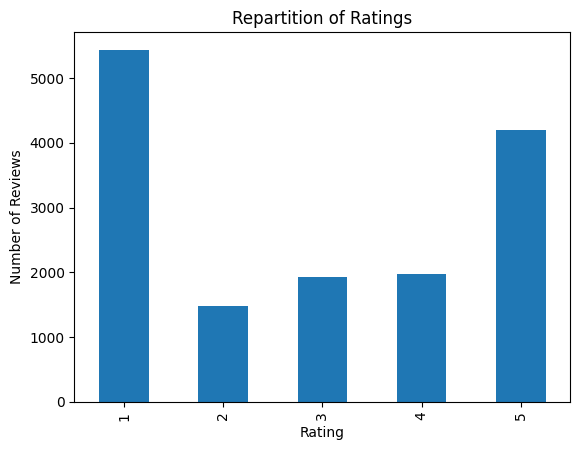

In [5]:
# Define the desired order of ratings
desired_order = [1, 2, 3, 4, 5]

# Calculate the counts of each rating
rating_counts = rws['rating'].value_counts()

# Reindex the rating_counts Series with the desired order
rating_counts = rating_counts.reindex(desired_order)

# Plot the repartition of ratings with the updated x-axis order
rating_counts.plot(kind='bar')

# Set the labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Repartition of Ratings')

# Show the plot
plt.show()


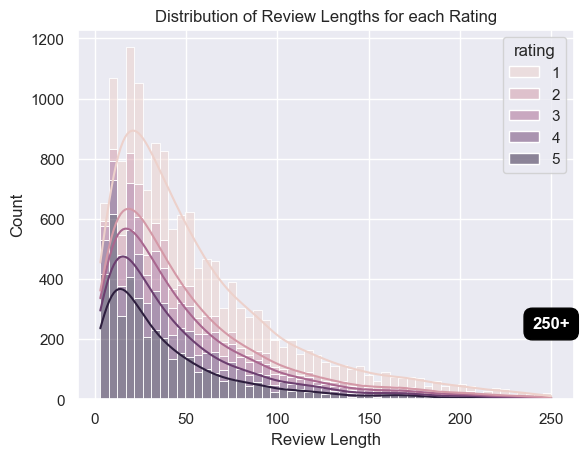

In [6]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set the style of the plot
sns.set(style="darkgrid")

# Calculate the length of reviews
rws['review_length'] = rws['review'].apply(len)

# Filter the review lengths greater than 250
filtered_rws = rws[rws['review_length'] <= 250]

# Plot the distribution of review lengths for each rating
sns.histplot(data=filtered_rws, x="review_length", hue="rating", multiple="stack", kde=True)

# Set the title and labels
plt.title("Distribution of Review Lengths for each Rating")
plt.xlabel("Review Length")
plt.ylabel("Count")

# Add a label for review lengths greater than 250
plt.text(250, 250, '250+', ha='center', va='center', color='white', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.show()

In [7]:
# Define a function to preprocess the reviews
longest_review = rws.loc[rws['review_length'].idxmax(), 'review']

print(longest_review)

When the delivery man arrived at my house, he called me to let me know that he had sent the food upstairs with my guard. I asked him to kindly wait downstairs so that I can send him the money to which he replied said the food has been paid for. I was quite taken aback and said that's not possible because I had opted for COD payment, and he just said "achcha ami dekhtesi" and then he just hung up on my face " I mean? Excuse me? I obviously lost my temper, called him back and asked him what sort of nonsense is this and why he kept the phone on my face. He was dumbfounded and did not say a word. I asked him to wait downstairs while I send the guard with the payment. Once your delivery-man had received the payment, he had the audacity to call me back and ask why I said what I said. To recall the conversation, when he hung up on my face my exact words when I called him back were "apni amar mukher upor keno phone rakhlen? Faizlami peyechen apni? Ami toh bolchi cash eh payment hobe, apni nich

In [8]:
rws.drop('review_length', axis=1, inplace=True)

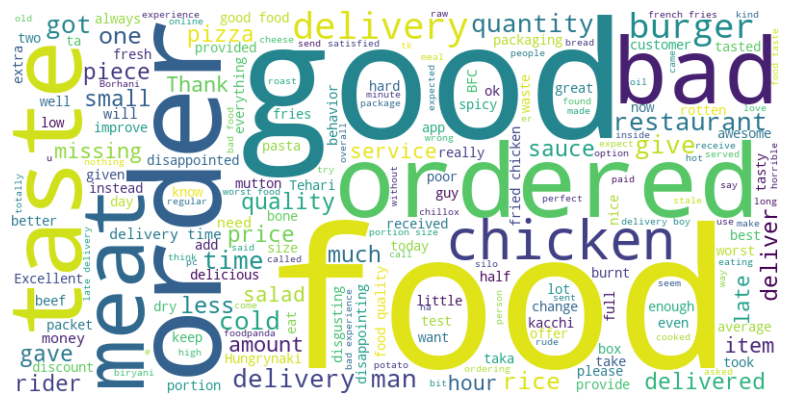

In [9]:
# Concatenate all the reviews into a single string
all_reviews = ' '.join(rws['review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Text Preprocessing and Data Categorization

### Data Categorization

I will create two categories for my reviews: Positive reviews, which are those with a rating strictly greater than 3, and Negative reviews, which include reviews with a rating strictly less than 3.

In [10]:
# Define a function that categorizes the rating
def categorize_rating(rating):
    if rating > 3:
        return 1
    elif rating < 3:
        return 0
    else:
        return 'Neutral'  # This handles ratings exactly equal to 3

# Apply the function to the 'rating' column
rws['rating'] = rws['rating'].apply(categorize_rating)

# Remove rows where the review_category is 'Neutral'
rws = rws[rws['rating'] != 'Neutral']

# Display the DataFrame to verify that 'Neutral' reviews have been removed
print(rws.head())

                                              review rating
0  To tell you the truth, they sell fried chicken...      0
2  The restaurant provided leas items which I ord...      0
3  already send you a picture about my meal. tota...      0
4                                Excellent as before      1
5  They forgot to include the beverages that were...      0


### Vizualization of the Categorization

Let's take a look at our newly categorized data to gain a clearer insight into how our future models will perform.

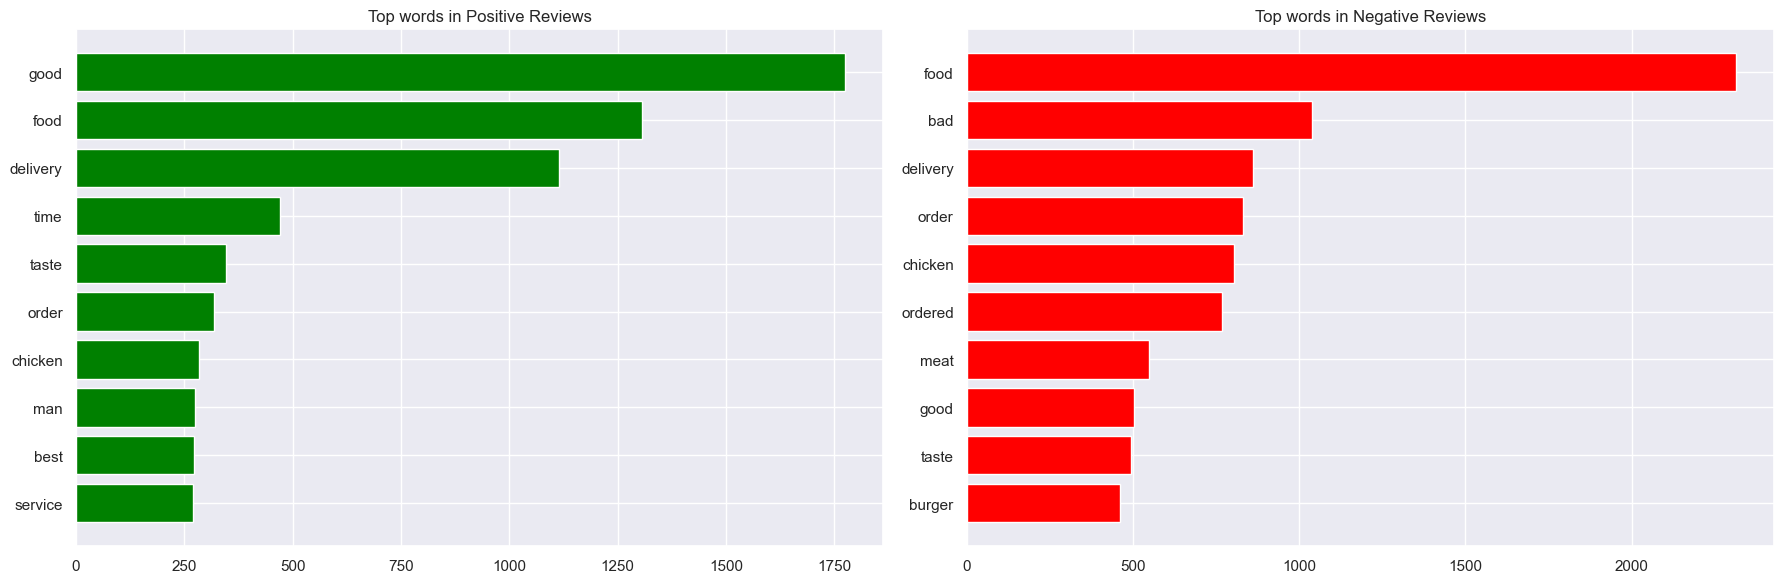

In [11]:
# Tokenize the reviews, remove stopwords, and count the word frequencies for positive and negative reviews separately.

# Function to clean and tokenize text
def clean_tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Separate positive and negative reviews
positive_reviews = rws[rws['rating'] == 1]['review']
negative_reviews = rws[rws['rating'] == 0]['review']

# Apply the cleaning and tokenization function
positive_tokens = positive_reviews.apply(clean_tokenize).sum()
negative_tokens = negative_reviews.apply(clean_tokenize).sum()

# Count the frequencies of words
positive_freq = Counter(positive_tokens)
negative_freq = Counter(negative_tokens)

# Get the 10 most common words in positive and negative reviews
most_common_positive = positive_freq.most_common(10)
most_common_negative = negative_freq.most_common(10)

# Separate the words and their counts for the plot
positive_words, positive_counts = zip(*most_common_positive)
negative_words, negative_counts = zip(*most_common_negative)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot for positive reviews
ax[0].barh(positive_words, positive_counts, color='green')
ax[0].set_title('Top words in Positive Reviews')
ax[0].invert_yaxis()  # Labels read top-to-bottom

# Plot for negative reviews
ax[1].barh(negative_words, negative_counts, color='red')
ax[1].set_title('Top words in Negative Reviews')
ax[1].invert_yaxis()  # Labels read top-to-bottom

# Display the plot
plt.tight_layout()
plt.show()


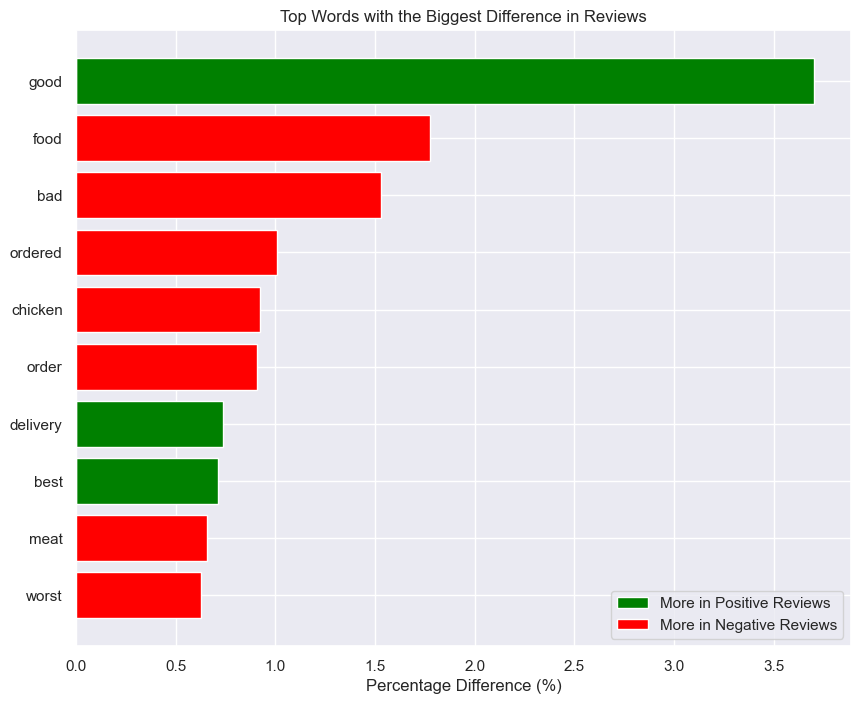

In [12]:
# Calculate the frequency difference for each word
frequency_diff = {word: positive_freq[word] - negative_freq[word] for word in set(positive_freq) | set(negative_freq)}

# Calculate the percentage difference for each word
total_pos_reviews = sum(positive_freq.values())
total_neg_reviews = sum(negative_freq.values())
percentage_diff = {word: (count / total_pos_reviews * 100 if count > 0 else count / total_neg_reviews * 100)
                   for word, count in frequency_diff.items()}

# Sort the words by the biggest absolute percentage difference
sorted_words = sorted(percentage_diff.items(), key=lambda x: abs(x[1]), reverse=True)

# Select the top words with the biggest difference
top_words = sorted_words[:10]  # Adjust the number as needed

# Split words and their percentage difference
words, differences = zip(*top_words)

# Split into positive and negative differences
pos_diffs = [percentage_diff[word] if percentage_diff[word] > 0 else 0 for word in words]
neg_diffs = [-percentage_diff[word] if percentage_diff[word] < 0 else 0 for word in words]

# Plotting
plt.figure(figsize=(10, 8))
y_pos = range(len(words))
plt.barh(y_pos, pos_diffs, color='green', label='More in Positive Reviews')
plt.barh(y_pos, neg_diffs, color='red', label='More in Negative Reviews')
plt.yticks(y_pos, words)
plt.xlabel('Percentage Difference (%)')
plt.title('Top Words with the Biggest Difference in Reviews')
plt.legend()
plt.gca().invert_yaxis()  # Highest percentages on top
plt.show()


### Text Preprocessing and Spliting

I will do text preprocessing in two distinct ways: 

**Large Cleaning Process :** This includes negation handling, emoji removal, lemmatization etc...

**Small Cleaning Process :** This maintaining more of the text's raw form.

*It will be beneficial to evaluate both versions with various models later on.*

Then I will also split the data into training and testing sets.

In [13]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def handle_negation(text):
    if text is None:
        return text
    # Pattern to detect negations followed by an alphanumeric word
    negation_pattern = re.compile(r'\b(not|no|never|none|nothing|nowhere|neither|nobody|cannot)\b[\s]*(\w+)')
    text = negation_pattern.sub(lambda x: f'{x.group(1)}_{x.group(2)}', text)
    return text

def full_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Handle negation
    text = handle_negation(text)
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # POS tagging
    nltk_pos_tagged = nltk.pos_tag(words)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_pos_tagged)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    return ' '.join(lemmatized_words)

def raw_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Tokenize text
    words = word_tokenize(text)
    return ' '.join(words)

In [14]:
# Balance the dataset
# Separate the dataset into positives and negatives
positive_rws = rws[rws['rating'] == 1]
negative_rws = rws[rws['rating'] == 0]

# Downsample the majority class (positive reviews) to match the minority class (negative reviews)
min_count = min(len(positive_rws), len(negative_rws))
balanced_positive = positive_rws.sample(n=min_count, random_state=42)
balanced_negative = negative_rws.sample(n=min_count, random_state=42)

# Combine back to a single balanced dataframe
balanced_rws = pd.concat([balanced_positive, balanced_negative])

# Now perform a stratified split on the balanced dataset
train_rws, test_rws = train_test_split(balanced_rws, test_size=0.2, stratify=balanced_rws['rating'], random_state=42)

# Apply the thorough cleaning to the training and test sets
# Create new DataFrame for cleaned versions including ratings
cleaned_train = pd.DataFrame({
    'review': train_rws['review'].apply(full_clean_text),
    'rating': train_rws['rating']
})
cleaned_test = pd.DataFrame({
    'review': test_rws['review'].apply(full_clean_text),
    'rating': test_rws['rating']
})

# Apply the minimal cleaning to the training and test sets
# Create new DataFrame for raw versions including ratings
raw_train = pd.DataFrame({
    'review': train_rws['review'].apply(raw_clean_text),
    'rating': train_rws['rating']
})
raw_test = pd.DataFrame({
    'review': test_rws['review'].apply(raw_clean_text),
    'rating': test_rws['rating']
})

In [15]:
# Print the first two reviews from the cleaned training set
print("First two reviews from the Cleaned Training Set:")
print(cleaned_train['review'].iloc[0])
print(cleaned_train['review'].iloc[1])
print("\n")

# Print the first two reviews from the cleaned test set
print("First two reviews from the Cleaned Test Set:")
print(cleaned_test['review'].iloc[0])
print(cleaned_test['review'].iloc[1])
print("\n")

# Assuming the same indices can be used for the raw sets, since the split was stratified based on the rating
print("First two reviews from the Raw Training Set:")
print(raw_train['review'].iloc[0])
print(raw_train['review'].iloc[1])
print("\n")

print("First two reviews from the Raw Test Set:")
print(raw_test['review'].iloc[0])
print(raw_test['review'].iloc[1])

First two reviews from the Cleaned Training Set:
bhuna khichuri plenty meatbeef ittaste also good
delivery time


First two reviews from the Cleaned Test Set:
bad food cold soggy bag rip entire soda go waste no_cheese cheeseburger
please continue consistency pizza excellent taste really fresh also whole family could enjoy definitely order


First two reviews from the Raw Training Set:
Bhuna khichuri had plenty of meat ( Beef ) in it.Taste was also good .
delivery time


First two reviews from the Raw Test Set:
It was very bad . The food was cold and soggy . The bag ripped and my entire soda went to waste . And there was no cheese in my cheeseburger
Please continue this consistency ! The pizza is excellent ! It tasted really fresh ! Also my whole family could enjoy it . Definitely ordering again .


In [16]:
# Count the occurrences of each class in the 'rating' column for both training and test sets
count_train = Counter(cleaned_train['rating'])
count_test = Counter(cleaned_test['rating'])
count_raw_train = Counter(raw_train['rating'])
count_raw_test = Counter(raw_test['rating'])

print("Counts for Cleaned Training Set:", count_train)
print("Counts for Cleaned Test Set:", count_test)
print("Counts for Raw Training Set:", count_raw_train)
print("Counts for Raw Test Set:", count_raw_test)


Counts for Cleaned Training Set: Counter({1: 4942, 0: 4942})
Counts for Cleaned Test Set: Counter({0: 1236, 1: 1236})
Counts for Raw Training Set: Counter({1: 4942, 0: 4942})
Counts for Raw Test Set: Counter({0: 1236, 1: 1236})


## Modelling

### Naive Bayes

First, I will be evaluating a Multinomial Naive Bayes model as my baseline

#### Naive Bayes with cleaned data (TF-IDF)

In [17]:
# Convert ratings to numeric codes if they are categorical
cleaned_train['rating'] = cleaned_train['rating'].astype('category').cat.codes
cleaned_test['rating'] = cleaned_test['rating'].astype('category').cat.codes

cX_train = cleaned_train['review']
cy_train = cleaned_train['rating']
cX_test = cleaned_test['review']
cy_test = cleaned_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
cX_train_tfidf = tfidf_vectorizer.fit_transform(cX_train)
cX_test_tfidf = tfidf_vectorizer.transform(cX_test)

# Training a Multinomial Naive Bayes model
model_0cTI = MultinomialNB()
model_0cTI.fit(cX_train_tfidf, cy_train)

# Predicting the ratings
start_time = timeit.default_timer()
cy_pred = model_0cTI.predict(cX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0cTI_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate other metrics
m0cTI_accuracy = accuracy_score(cy_test, cy_pred)
m0cTI_precision = precision_score(cy_test, cy_pred, average='weighted')
m0cTI_recall = recall_score(cy_test, cy_pred, average='weighted')
m0cTI_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0cTI_accuracy:.2%}", f"{m0cTI_precision:.3f}", f"{m0cTI_recall:.3f}", f"{m0cTI_f1:.3f}", f"{m0cTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


Model Performance          Results
         accuracy           78.80%
        precision            0.793
           recall            0.788
         f1_score            0.787
    time/instance 0.000000 seconds


#### Naive Bayes with raw data (TF-IDF)

In [18]:
# Convert ratings to numeric codes if they are categorical
raw_train['rating'] = raw_train['rating'].astype('category').cat.codes
raw_test['rating'] = raw_test['rating'].astype('category').cat.codes

rX_train = raw_train['review']
ry_train = raw_train['rating']
rX_test = raw_test['review']
ry_test = raw_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
rX_train_tfidf = tfidf_vectorizer.fit_transform(rX_train)
rX_test_tfidf = tfidf_vectorizer.transform(rX_test)

# Training a Multinomial Naive Bayes model
model_0rTI = MultinomialNB()
model_0rTI.fit(rX_train_tfidf, ry_train)

# Predicting the ratings
start_time = timeit.default_timer()
ry_pred = model_0rTI.predict(rX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0rTI_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate other metrics
m0rTI_accuracy = accuracy_score(ry_test, ry_pred)
m0rTI_precision = precision_score(ry_test, ry_pred, average='weighted')
m0rTI_recall = recall_score(ry_test, ry_pred, average='weighted')
m0rTI_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0rTI_accuracy:.2%}", f"{m0rTI_precision:.3f}", f"{m0rTI_recall:.3f}", f"{m0rTI_f1:.3f}", f"{m0rTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

Model Performance          Results
         accuracy           78.92%
        precision            0.795
           recall            0.789
         f1_score            0.788
    time/instance 0.000000 seconds


#### Storing Results

In [19]:
# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Time per Instance'])

def store_results(model_name, accuracy, precision, recall, f1_score, time_per_instance):
    # Append the new results to the DataFrame
    results_df.loc[len(results_df)] = {
        'Model': model_name,
        'Accuracy': f"{accuracy:.2%}",
        'Precision': f"{precision:.3f}",
        'Recall': f"{recall:.3f}",
        'F1 Score': f"{f1_score:.3f}",
        'Time per Instance': f"{time_per_instance:.6f} seconds"
    }

# Store the results for the cleaned text model with TF-IDF
store_results('Model_0cTI', m0cTI_accuracy, m0cTI_precision, m0cTI_recall, m0cTI_f1, m0cTI_time_per_instance)

# Store the results for the raw text model with TF-IDF
store_results('Model_0rTI', m0rTI_accuracy, m0rTI_precision, m0rTI_recall, m0rTI_f1, m0rTI_time_per_instance)

# View the consolidated results
print(results_df)


        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds


### FNN

My initial model is a Feedforward Neural Network (FNN) with 2 different vectorization (TF-IDF and Word2Vec)

#### FNN with cleaned data (TF-IDF)

In [ ]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.01):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_tfidf.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.01, epochs=30, batch_size=32, verbose=1)

In [ ]:
param_grid = {
    'neurons': [128, 256],  # Starting neurons for the first layer
    'num_layers': [1, 2],  # Varying numbers of layers
    'learning_rate': [0.001, 0.0001],
    'regularization': [0, 0.001]  # Adding regularization to the grid search
}


# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(cX_train_tfidf, cy_train, callbacks=[early_stopping])

In [ ]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.793807 using {'learning_rate': 0.0001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.733204 (0.006053) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.782172 (0.008474) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.736037 (0.007400) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.770538 (0.001989) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.730675 (0.005297) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.776506 (0.007473) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.734621 (0.006017) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.762344 (0.003727) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.788040 (0.007465) with: {'learning_ra

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_1cTI = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1cTI.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_122 (Dense)               │ (None, 256)            │     1,714,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,714,433 (6.54 MB)

 Trainable params: 1,714,433 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

None


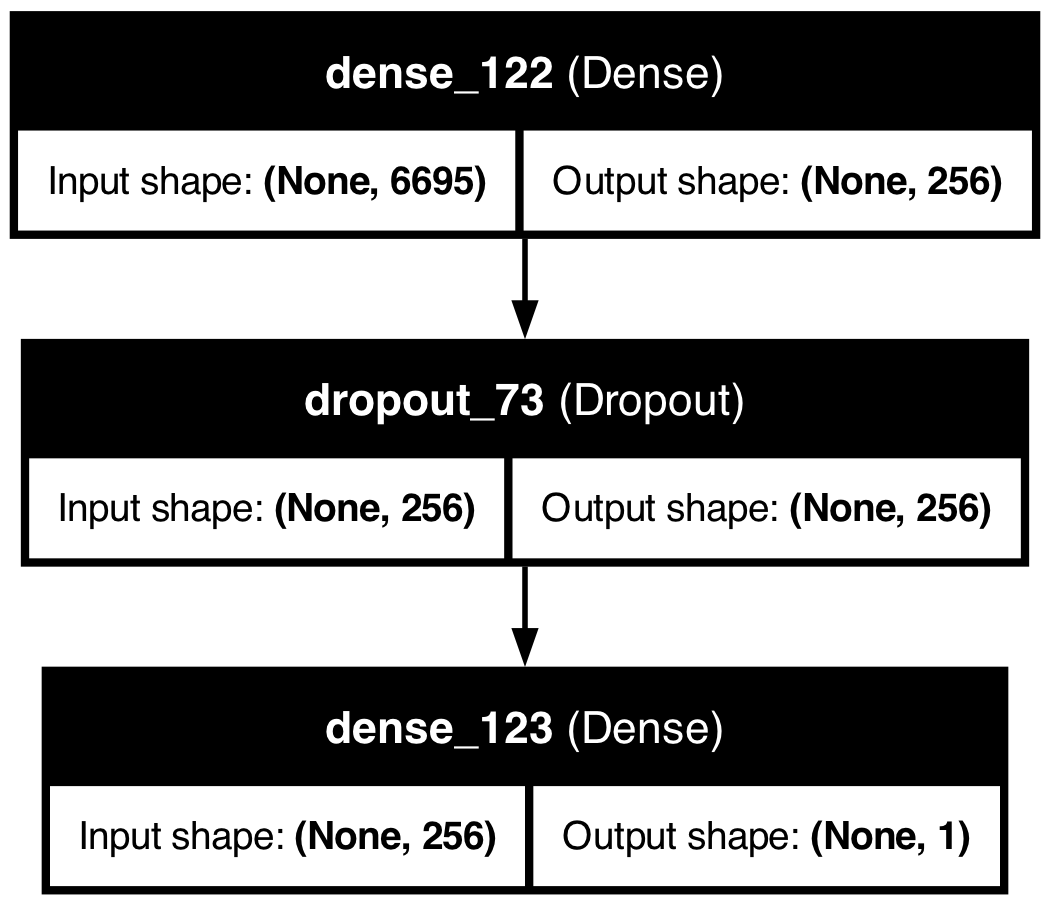

In [ ]:
# Generate the plot
plot_model(model_1cTI, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1cTI_history = model_1cTI.fit(
    cX_train_tfidf, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/300
244/248 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6461 - loss: 1.0079
Epoch 1: val_loss improved from inf to 0.72937, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6475 - loss: 1.0055 - val_accuracy: 0.7648 - val_loss: 0.7294 - learning_rate: 1.0000e-04
Epoch 2/300
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7909 - loss: 0.7018
Epoch 2: val_loss improved from 0.72937 to 0.65575, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7909 - loss: 0.7016 - val_accuracy: 0.7658 - val_loss: 0.6558 - learning_rate: 1.0000e-04
Epoch 3/300
245/248 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8036 - loss: 0.6393
Epoch 3: val_loss improved from 0.65575 to 0.61727, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8035 - loss: 0.6392 - val_accuracy: 0.7693 - val_loss: 0.6173 - learning_rate: 1.0000e-04
Epoch 4/300
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

In [ ]:
# Create a function to vizuualize the training and validation loss and accuracy
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
    history: TensorFlow History object.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Use the function with your model's history
plot_loss_curves(model_1cTI_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_1cTI.predict(cX_test_tfidf)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1cTI_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m1cTI_accuracy = accuracy_score(cy_test, cy_pred)
m1cTI_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1cTI_recall = recall_score(cy_test, cy_pred, average='weighted')
m1cTI_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1cTI_accuracy:.2%}", f"{m1cTI_precision:.3f}", f"{m1cTI_recall:.3f}", f"{m1cTI_f1:.3f}", f"{m1cTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Performance          Results
         accuracy           78.20%
        precision            0.784
           recall            0.782
         f1_score            0.782
    time/instance 0.000265 seconds


In [ ]:
store_results('Model_1cTI', m1cTI_accuracy, m1cTI_precision, m1cTI_recall, m1cTI_f1, m1cTI_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.784  0.782    0.782  0.000265 seconds


#### FNN with raw data (TF-IDF)

In [ ]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.01):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_tfidf.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.01, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(rX_train_tfidf, ry_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6811 - loss: 0.6441
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8265 - loss: 0.4276
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8510 - loss: 0.3623
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8821 - loss: 0.3045
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8854 - loss: 0.2825
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8989 - loss: 0.2678
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9103 - loss: 0.2440
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9090 - loss: 0.2415
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9099 - loss: 0.2264
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9182 - loss: 0.2187
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9153 - loss: 0.2124
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7054 - loss: 0.6454
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8255 - loss: 0.4339
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8553 - loss: 0.3511
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8796 - loss: 0.3097
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8912 - loss: 0.2843
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9039 - loss: 0.2590
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9104 - loss: 0.2314
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9146 - loss: 0.2275
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9207 - loss: 0.2091
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9253 - loss: 0.2010
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9294 - loss: 0.1881
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accurac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6924 - loss: 0.6461
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8299 - loss: 0.4240
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8580 - loss: 0.3465
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8874 - loss: 0.2926
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8938 - loss: 0.2764
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9030 - loss: 0.2618
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9115 - loss: 0.2359
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9126 - loss: 0.2317
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9215 - loss: 0.2106
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9175 - loss: 0.2154
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9260 - loss: 0.1955
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7080 - loss: 0.7149
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8036 - loss: 0.5409
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8210 - loss: 0.5121
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8247 - loss: 0.4991
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8275 - loss: 0.5009
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8248 - loss: 0.4914
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8326 - loss: 0.4761
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8321 - loss: 0.4811
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8506 - loss: 0.4606
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8406 - loss: 0.4661
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8397 - loss: 0.4694
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6732 - loss: 0.7137
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8015 - loss: 0.5380
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8212 - loss: 0.5090
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8208 - loss: 0.4989
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8319 - loss: 0.4917
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8315 - loss: 0.4840
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8473 - loss: 0.4691
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8501 - loss: 0.4648
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8499 - loss: 0.4632
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8444 - loss: 0.4616
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8475 - loss: 0.4589
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accurac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6972 - loss: 0.7130
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8057 - loss: 0.5355
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8131 - loss: 0.5159
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8338 - loss: 0.4920
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8353 - loss: 0.4824
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8358 - loss: 0.4784
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8387 - loss: 0.4760
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8456 - loss: 0.4608
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8457 - loss: 0.4612
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8513 - loss: 0.4548
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8496 - loss: 0.4598
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6882 - loss: 0.6161
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8458 - loss: 0.3635
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8800 - loss: 0.3043
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8958 - loss: 0.2714
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9034 - loss: 0.2460
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9130 - loss: 0.2227
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9191 - loss: 0.2079
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9255 - loss: 0.2030
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9242 - loss: 0.1943
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9266 - loss: 0.1914
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9286 - loss: 0.1839
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6867 - loss: 0.6173
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8489 - loss: 0.3634
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8785 - loss: 0.3033
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9028 - loss: 0.2506
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9074 - loss: 0.2358
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9125 - loss: 0.2208
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9129 - loss: 0.2129
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9232 - loss: 0.1953
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9226 - loss: 0.1882
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9335 - loss: 0.1706
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9287 - loss: 0.1812
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6979 - loss: 0.6111
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8526 - loss: 0.3584
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8857 - loss: 0.2814
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9008 - loss: 0.2598
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9105 - loss: 0.2303
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9177 - loss: 0.2138
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9199 - loss: 0.2059
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9260 - loss: 0.1884
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9227 - loss: 0.1932
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9244 - loss: 0.1869
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9295 - loss: 0.1721
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6629 - loss: 0.7539
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8206 - loss: 0.5102
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8403 - loss: 0.4973
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8335 - loss: 0.4923
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8506 - loss: 0.4820
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8503 - loss: 0.4746
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8605 - loss: 0.4634
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8582 - loss: 0.4710
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8716 - loss: 0.4396
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8687 - loss: 0.4402
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8695 - loss: 0.4478
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6772 - loss: 0.7544
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8163 - loss: 0.5156
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8408 - loss: 0.4882
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8466 - loss: 0.4767
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8569 - loss: 0.4672
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8621 - loss: 0.4607
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8703 - loss: 0.4471
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8646 - loss: 0.4513
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8743 - loss: 0.4376
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8781 - loss: 0.4367
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8811 - loss: 0.4249
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6704 - loss: 0.7558
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8244 - loss: 0.5084
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8444 - loss: 0.4875
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8544 - loss: 0.4684
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8542 - loss: 0.4591
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8598 - loss: 0.4593
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8703 - loss: 0.4453
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8788 - loss: 0.4336
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8708 - loss: 0.4337
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8810 - loss: 0.4303
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8840 - loss: 0.4194
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7173 - loss: 0.6278
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8254 - loss: 0.4017
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8677 - loss: 0.3228
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8839 - loss: 0.2890
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8996 - loss: 0.2588
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9080 - loss: 0.2417
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9182 - loss: 0.2269
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9175 - loss: 0.2222
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9175 - loss: 0.2143
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9264 - loss: 0.2037
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9350 - loss: 0.1823
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6973 - loss: 0.6295
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8307 - loss: 0.4016
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8692 - loss: 0.3281
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8859 - loss: 0.2940
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8940 - loss: 0.2608
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9159 - loss: 0.2258
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9189 - loss: 0.2103
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9133 - loss: 0.2178
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9193 - loss: 0.2082
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9237 - loss: 0.1915
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9263 - loss: 0.1803
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7302 - loss: 0.6246
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8231 - loss: 0.3961
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8728 - loss: 0.3215
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8924 - loss: 0.2820
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9063 - loss: 0.2472
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9149 - loss: 0.2288
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9216 - loss: 0.2025
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9213 - loss: 0.2081
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9224 - loss: 0.2007
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9269 - loss: 0.1904
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9297 - loss: 0.1817
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6878 - loss: 0.7514
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7936 - loss: 0.5461
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8203 - loss: 0.5183
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8142 - loss: 0.5177
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8326 - loss: 0.5026
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8304 - loss: 0.4990
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8287 - loss: 0.5046
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8344 - loss: 0.4948
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8323 - loss: 0.4994
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8405 - loss: 0.4877
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8412 - loss: 0.4808
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6936 - loss: 0.7529
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7963 - loss: 0.5449
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8246 - loss: 0.5082
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8289 - loss: 0.5072
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8253 - loss: 0.5039
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8352 - loss: 0.4902
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8345 - loss: 0.4918
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8356 - loss: 0.4927
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8479 - loss: 0.4861
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8476 - loss: 0.4819
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8507 - loss: 0.4760
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6959 - loss: 0.7527
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8087 - loss: 0.5306
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8208 - loss: 0.5035
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8259 - loss: 0.5059
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8330 - loss: 0.4932
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8328 - loss: 0.4993
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8391 - loss: 0.4859
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8289 - loss: 0.4914
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8373 - loss: 0.4844
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8421 - loss: 0.4859
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8395 - loss: 0.4810
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6869 - loss: 0.5926
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8522 - loss: 0.3574
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8833 - loss: 0.2833
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9031 - loss: 0.2452
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9092 - loss: 0.2363
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9129 - loss: 0.2198
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9267 - loss: 0.2083
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9220 - loss: 0.2059
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9235 - loss: 0.1903
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9240 - loss: 0.1882
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9252 - loss: 0.1931
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7029 - loss: 0.5951
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8431 - loss: 0.3611
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8887 - loss: 0.2755
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8970 - loss: 0.2532
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9133 - loss: 0.2282
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9134 - loss: 0.2124
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9198 - loss: 0.1972
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9241 - loss: 0.1938
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9234 - loss: 0.1901
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9214 - loss: 0.1856
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9347 - loss: 0.1685
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7050 - loss: 0.5905
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8492 - loss: 0.3569
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8863 - loss: 0.2877
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8996 - loss: 0.2483
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9141 - loss: 0.2269
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9188 - loss: 0.2043
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9169 - loss: 0.2139
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9251 - loss: 0.1862
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9290 - loss: 0.1822
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9340 - loss: 0.1677
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9284 - loss: 0.1686
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6765 - loss: 0.8256
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8248 - loss: 0.5243
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8237 - loss: 0.5168
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8340 - loss: 0.4989
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8406 - loss: 0.4977
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8502 - loss: 0.4823
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8506 - loss: 0.4643
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8549 - loss: 0.4660
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8664 - loss: 0.4450
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8680 - loss: 0.4422
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8722 - loss: 0.4326
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6845 - loss: 0.8250
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8204 - loss: 0.5290
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8346 - loss: 0.5100
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8432 - loss: 0.4948
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8578 - loss: 0.4843
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8515 - loss: 0.4807
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8585 - loss: 0.4645
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8764 - loss: 0.4458
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8751 - loss: 0.4405
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8729 - loss: 0.4309
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8832 - loss: 0.4292
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6913 - loss: 0.8239
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8202 - loss: 0.5182
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8398 - loss: 0.4984
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8346 - loss: 0.4946
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8537 - loss: 0.4811
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8607 - loss: 0.4641
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8655 - loss: 0.4534
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8729 - loss: 0.4397
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8726 - loss: 0.4361
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8833 - loss: 0.4288
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8851 - loss: 0.4127
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6141 - loss: 0.6900
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7721 - loss: 0.6722
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7794 - loss: 0.6475
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7941 - loss: 0.6135
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8055 - loss: 0.5799
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8144 - loss: 0.5435
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8159 - loss: 0.5165
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8221 - loss: 0.4912
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8263 - loss: 0.4709
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8316 - loss: 0.4499
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8448 - loss: 0.4252
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6134 - loss: 0.6892
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7806 - loss: 0.6702
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8005 - loss: 0.6433
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8123 - loss: 0.6082
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8136 - loss: 0.5750
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8152 - loss: 0.5424
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8295 - loss: 0.5108
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8396 - loss: 0.4823
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8367 - loss: 0.4626
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8388 - loss: 0.4451
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8471 - loss: 0.4223
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6151 - loss: 0.6893
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7646 - loss: 0.6699
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7894 - loss: 0.6425
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8067 - loss: 0.6094
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8113 - loss: 0.5728
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8164 - loss: 0.5406
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8240 - loss: 0.5063
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8269 - loss: 0.4847
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8377 - loss: 0.4547
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8462 - loss: 0.4313
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8417 - loss: 0.4213
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6130 - loss: 0.8664
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7546 - loss: 0.7129
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7768 - loss: 0.6688
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7946 - loss: 0.6409
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7937 - loss: 0.6157
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7954 - loss: 0.5954
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7951 - loss: 0.5778
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8003 - loss: 0.5581
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8137 - loss: 0.5441
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8061 - loss: 0.5403
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8028 - loss: 0.5346
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6385 - loss: 0.8654
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7579 - loss: 0.7111
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7873 - loss: 0.6693
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7989 - loss: 0.6399
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7991 - loss: 0.6157
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8037 - loss: 0.5937
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8079 - loss: 0.5758
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8031 - loss: 0.5595
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8114 - loss: 0.5499
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8110 - loss: 0.5378
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8049 - loss: 0.5351
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5923 - loss: 0.8664
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7763 - loss: 0.7114
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7857 - loss: 0.6688
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7880 - loss: 0.6437
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7965 - loss: 0.6163
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7965 - loss: 0.5946
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8103 - loss: 0.5747
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8133 - loss: 0.5563
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8175 - loss: 0.5498
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8283 - loss: 0.5302
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8181 - loss: 0.5264
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6008 - loss: 0.6911
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7772 - loss: 0.6724
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7853 - loss: 0.6035
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8100 - loss: 0.5051
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8308 - loss: 0.4376
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8425 - loss: 0.3869
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8484 - loss: 0.3639
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8615 - loss: 0.3444
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8724 - loss: 0.3209
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8663 - loss: 0.3130
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8788 - loss: 0.3037
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5862 - loss: 0.6917
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7771 - loss: 0.6747
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7963 - loss: 0.6122
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8229 - loss: 0.5081
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8381 - loss: 0.4344
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8455 - loss: 0.3890
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8626 - loss: 0.3504
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8642 - loss: 0.3404
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8728 - loss: 0.3267
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8761 - loss: 0.3123
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8873 - loss: 0.2964
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5861 - loss: 0.6912
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7637 - loss: 0.6703
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7980 - loss: 0.5943
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8177 - loss: 0.4888
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8392 - loss: 0.4180
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8436 - loss: 0.3866
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8547 - loss: 0.3556
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8690 - loss: 0.3366
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8743 - loss: 0.3254
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8848 - loss: 0.3002
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8879 - loss: 0.2944
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5926 - loss: 0.9439
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7586 - loss: 0.7707
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7716 - loss: 0.7131
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7795 - loss: 0.6520
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8042 - loss: 0.5851
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8120 - loss: 0.5496
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8218 - loss: 0.5277
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8340 - loss: 0.5011
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8296 - loss: 0.4962
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8423 - loss: 0.4866
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8422 - loss: 0.4804
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6026 - loss: 0.9461
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7759 - loss: 0.7722
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7777 - loss: 0.7088
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7947 - loss: 0.6396
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8075 - loss: 0.5842
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8216 - loss: 0.5385
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8372 - loss: 0.5092
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8361 - loss: 0.5009
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8369 - loss: 0.4924
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8426 - loss: 0.4811
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8464 - loss: 0.4713
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6076 - loss: 0.9461
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7451 - loss: 0.7723
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7771 - loss: 0.7108
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7941 - loss: 0.6419
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8077 - loss: 0.5766
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8221 - loss: 0.5340
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8376 - loss: 0.5063
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8460 - loss: 0.4972
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8460 - loss: 0.4781
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8436 - loss: 0.4771
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8575 - loss: 0.4621
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6360 - loss: 0.6877
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7901 - loss: 0.6592
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7950 - loss: 0.6179
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8051 - loss: 0.5719
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8250 - loss: 0.5203
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8269 - loss: 0.4855
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8294 - loss: 0.4563
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8375 - loss: 0.4299
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8459 - loss: 0.4072
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8482 - loss: 0.3906
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8491 - loss: 0.3858
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6310 - loss: 0.6883
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7718 - loss: 0.6598
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8037 - loss: 0.6179
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8142 - loss: 0.5707
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8208 - loss: 0.5251
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8411 - loss: 0.4791
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8395 - loss: 0.4556
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8388 - loss: 0.4279
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8475 - loss: 0.4109
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8556 - loss: 0.3864
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8606 - loss: 0.3754
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6440 - loss: 0.6878
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7842 - loss: 0.6580
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8008 - loss: 0.6156
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8111 - loss: 0.5683
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8248 - loss: 0.5179
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8272 - loss: 0.4860
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8378 - loss: 0.4491
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8410 - loss: 0.4261
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8414 - loss: 0.4071
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8442 - loss: 0.3965
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8631 - loss: 0.3709
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6493 - loss: 1.0296
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7661 - loss: 0.7284
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7816 - loss: 0.6591
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7795 - loss: 0.6235
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7900 - loss: 0.5940
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7887 - loss: 0.5701
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7961 - loss: 0.5496
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8099 - loss: 0.5327
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8171 - loss: 0.5208
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8179 - loss: 0.5100
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8137 - loss: 0.5098
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6226 - loss: 1.0309
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7796 - loss: 0.7291
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7867 - loss: 0.6594
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7937 - loss: 0.6221
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7994 - loss: 0.5910
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8053 - loss: 0.5685
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8098 - loss: 0.5475
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8161 - loss: 0.5295
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8183 - loss: 0.5239
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8236 - loss: 0.5109
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8192 - loss: 0.5064
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6015 - loss: 1.0309
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7778 - loss: 0.7283
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7912 - loss: 0.6582
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7964 - loss: 0.6155
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7982 - loss: 0.5904
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8096 - loss: 0.5657
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8093 - loss: 0.5495
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8189 - loss: 0.5288
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8178 - loss: 0.5232
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8242 - loss: 0.5136
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8178 - loss: 0.5126
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6273 - loss: 0.6899
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7629 - loss: 0.6412
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8058 - loss: 0.5002
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8234 - loss: 0.4183
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8516 - loss: 0.3663
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8552 - loss: 0.3439
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8726 - loss: 0.3211
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8726 - loss: 0.3105
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8843 - loss: 0.2962
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8940 - loss: 0.2751
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8926 - loss: 0.2619
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6190 - loss: 0.6898
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7843 - loss: 0.6400
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8162 - loss: 0.4995
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8386 - loss: 0.4110
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8539 - loss: 0.3651
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8721 - loss: 0.3234
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8723 - loss: 0.3165
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8832 - loss: 0.2977
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8955 - loss: 0.2685
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8949 - loss: 0.2732
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9029 - loss: 0.2485
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6040 - loss: 0.6895
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7762 - loss: 0.6377
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8172 - loss: 0.4907
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8358 - loss: 0.4091
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8573 - loss: 0.3520
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8705 - loss: 0.3232
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8835 - loss: 0.3034
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8920 - loss: 0.2918
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8986 - loss: 0.2642
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8980 - loss: 0.2649
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9084 - loss: 0.2482
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6242 - loss: 1.1834
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7628 - loss: 0.8238
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7855 - loss: 0.6913
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7990 - loss: 0.5876
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8145 - loss: 0.5441
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8253 - loss: 0.5232
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8347 - loss: 0.5031
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8444 - loss: 0.4854
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8552 - loss: 0.4706
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8464 - loss: 0.4650
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8552 - loss: 0.4579
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5819 - loss: 1.1830
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7735 - loss: 0.8249
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7876 - loss: 0.6951
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7991 - loss: 0.5965
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8228 - loss: 0.5433
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8349 - loss: 0.5154
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8351 - loss: 0.4987
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8485 - loss: 0.4798
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8528 - loss: 0.4712
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8528 - loss: 0.4679
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8649 - loss: 0.4559
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6114 - loss: 1.1823
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7542 - loss: 0.8224
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7808 - loss: 0.6948
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8082 - loss: 0.5896
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8281 - loss: 0.5402
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8365 - loss: 0.5089
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8421 - loss: 0.4938
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8541 - loss: 0.4738
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8551 - loss: 0.4621
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8622 - loss: 0.4551
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8637 - loss: 0.4543
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6514 - loss: 0.9815
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7758 - loss: 0.6795
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7852 - loss: 0.6182
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7934 - loss: 0.5790
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7994 - loss: 0.5534
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8086 - loss: 0.5291
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8040 - loss: 0.5218
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8158 - loss: 0.5085
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8081 - loss: 0.5058
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8142 - loss: 0.5050
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8170 - loss: 0.4923
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.795932 using {'learning_rate': 0.0001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.738971 (0.009708) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.784096 (0.002274) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.744232 (0.005629) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.775091 (0.002212) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.734215 (0.011432) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.776103 (0.005354) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.744537 (0.005749) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.771550 (0.001296) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.789255 (0.002537) with: {'learning_ra

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_1rTI = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1rTI.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_246 (Dense)               │ (None, 256)            │     1,610,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,753 (6.14 MB)

 Trainable params: 1,610,753 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

None


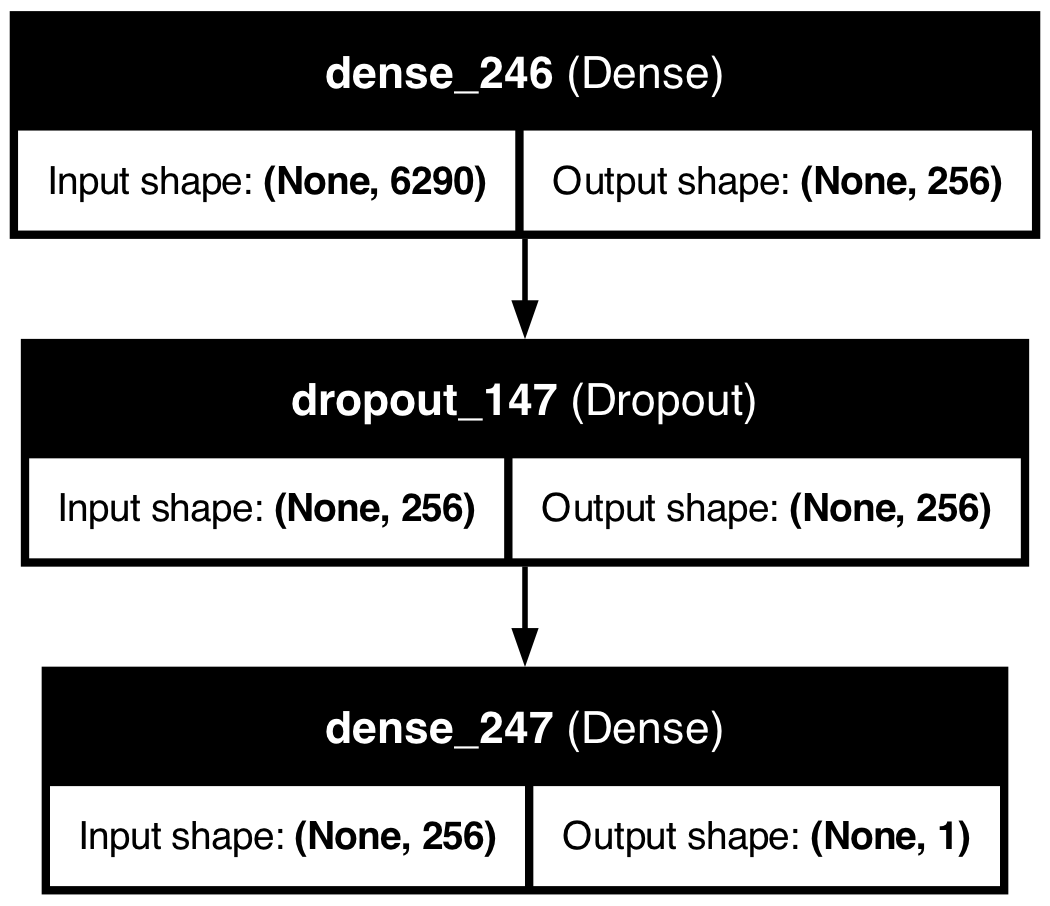

In [ ]:
# Generate the plot
plot_model(model_1rTI, show_shapes=True, show_layer_names=True)

Epoch 1/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6537 - loss: 1.0088
Epoch 1: val_loss improved from inf to 0.73188, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6539 - loss: 1.0083 - val_accuracy: 0.7415 - val_loss: 0.7319 - learning_rate: 1.0000e-04
Epoch 2/300
245/248 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7780 - loss: 0.7052
Epoch 2: val_loss improved from 0.73188 to 0.65697, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7780 - loss: 0.7049 - val_accuracy: 0.7704 - val_loss: 0.6570 - learning_rate: 1.0000e-04
Epoch 3/300
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7874 - loss: 0.6418
Epoch 3: val_loss improved from 0.65697 to 0.61885, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7874 - loss: 0.6417 - val_accuracy: 0.7724 - val_loss: 0.6189 - learning_rate: 1.0000e-04
Epoch 4/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

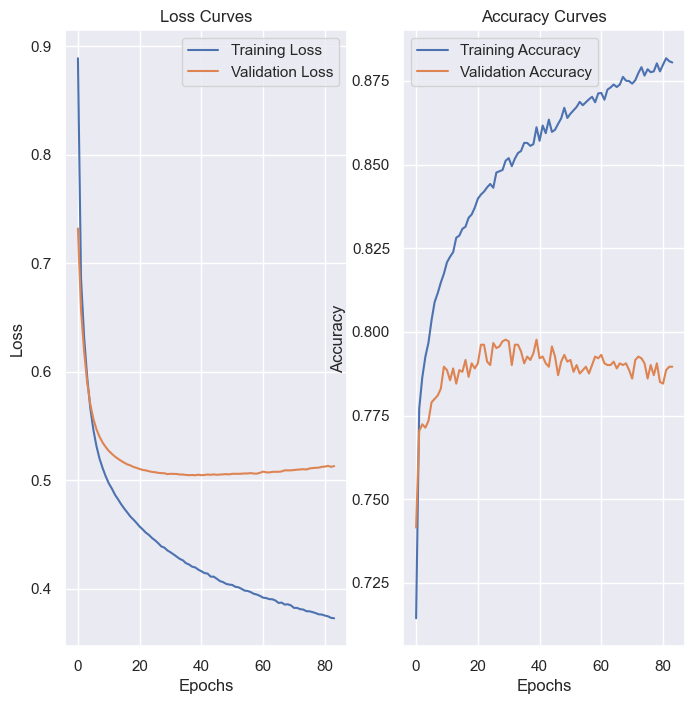

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=50, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1rTI_history = model_1rTI.fit(
    rX_train_tfidf, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_1rTI_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_1rTI.predict(rX_test_tfidf)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1rTI_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m1rTI_accuracy = accuracy_score(ry_test, ry_pred)
m1rTI_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1rTI_recall = recall_score(ry_test, ry_pred, average='weighted')
m1rTI_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1rTI_accuracy:.2%}", f"{m1rTI_precision:.3f}", f"{m1rTI_recall:.3f}", f"{m1rTI_f1:.3f}", f"{m1rTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Performance          Results
         accuracy           79.37%
        precision            0.796
           recall            0.794
         f1_score            0.793
    time/instance 0.000257 seconds


In [ ]:
store_results('Model_1rTI', m1rTI_accuracy, m1rTI_precision, m1rTI_recall, m1rTI_f1, m1rTI_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.784  0.782    0.782  0.000265 seconds
3  Model_1rTI   79.37%     0.796  0.794    0.793  0.000257 seconds


#### Word2Vec Vectorization

In [ ]:
# Tokenize reviews
cleaned_train['tokenized_reviews'] = cleaned_train['review'].apply(gensim.utils.simple_preprocess)
cleaned_test['tokenized_reviews'] = cleaned_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_c = Word2Vec(sentences=cleaned_train['tokenized_reviews'], vector_size=250, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
cX_train_vec = vectorize_reviews(cleaned_train['tokenized_reviews'], word2vec_model_c)
cX_test_vec = vectorize_reviews(cleaned_test['tokenized_reviews'], word2vec_model_c)

In [ ]:
# Tokenize reviews
raw_train['tokenized_reviews'] = raw_train['review'].apply(gensim.utils.simple_preprocess)
raw_test['tokenized_reviews'] = raw_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_r = Word2Vec(sentences=raw_train['tokenized_reviews'], vector_size=250, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
rX_train_vec = vectorize_reviews(raw_train['tokenized_reviews'], word2vec_model_r)
rX_test_vec = vectorize_reviews(raw_test['tokenized_reviews'], word2vec_model_r)

#### FNN with cleaned data (Word2Vec)

In [ ]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.01):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_vec.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.01, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(cX_train_vec, cy_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/30


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5233 - loss: 0.6949
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5354 - loss: 0.6884
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5520 - loss: 0.6860
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5648 - loss: 0.6803
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5954 - loss: 0.6721
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5965 - loss: 0.6730
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6064 - loss: 0.6638
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6063 - loss: 0.6603
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6158 - loss: 0.6531
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6162 - loss: 0.6483
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6351 - loss: 0.6436
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5085 - loss: 0.6948
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5418 - loss: 0.6860
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5651 - loss: 0.6827
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5708 - loss: 0.6779
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5858 - loss: 0.6692
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6045 - loss: 0.6678
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6224 - loss: 0.6599
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6228 - loss: 0.6533
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6371 - loss: 0.6464
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6409 - loss: 0.6424
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6483 - loss: 0.6310
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4993 - loss: 0.6964
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5276 - loss: 0.6915
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5660 - loss: 0.6848
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5734 - loss: 0.6795
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5876 - loss: 0.6731
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6017 - loss: 0.6686
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6210 - loss: 0.6581
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6296 - loss: 0.6503
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6211 - loss: 0.6537
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6413 - loss: 0.6401
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6538 - loss: 0.6339
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5149 - loss: 0.8139
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5315 - loss: 0.7309
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5316 - loss: 0.7139
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5402 - loss: 0.7045
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5417 - loss: 0.7000
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5411 - loss: 0.6971
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5397 - loss: 0.6964
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5337 - loss: 0.6947
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5335 - loss: 0.6962
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5500 - loss: 0.6931
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5318 - loss: 0.6938
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5281 - loss: 0.8105
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5062 - loss: 0.7300
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5232 - loss: 0.7111
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5266 - loss: 0.7036
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5493 - loss: 0.6986
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5391 - loss: 0.6966
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5387 - loss: 0.6955
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5313 - loss: 0.6958
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5484 - loss: 0.6926
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5508 - loss: 0.6926
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5351 - loss: 0.6921
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4985 - loss: 0.8233
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5200 - loss: 0.7396
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5219 - loss: 0.7186
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5310 - loss: 0.7078
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5461 - loss: 0.7024
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5435 - loss: 0.6978
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5291 - loss: 0.6982
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5482 - loss: 0.6955
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5308 - loss: 0.6955
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5417 - loss: 0.6940
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5355 - loss: 0.6942
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5057 - loss: 0.6958
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5311 - loss: 0.6929
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5396 - loss: 0.6904
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5619 - loss: 0.6821
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5831 - loss: 0.6748
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6078 - loss: 0.6672
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6189 - loss: 0.6592
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6256 - loss: 0.6476
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6294 - loss: 0.6433
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6317 - loss: 0.6333
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6561 - loss: 0.6200
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5011 - loss: 0.6960
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5353 - loss: 0.6900
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5480 - loss: 0.6881
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5683 - loss: 0.6787
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5924 - loss: 0.6722
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6063 - loss: 0.6645
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6308 - loss: 0.6513
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6348 - loss: 0.6446
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6392 - loss: 0.6359
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6470 - loss: 0.6231
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6586 - loss: 0.6202
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5260 - loss: 0.6931
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5174 - loss: 0.6939
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5475 - loss: 0.6876
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5703 - loss: 0.6789
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5942 - loss: 0.6728
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6209 - loss: 0.6583
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6350 - loss: 0.6476
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6368 - loss: 0.6346
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6495 - loss: 0.6269
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6719 - loss: 0.6147
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6698 - loss: 0.6140
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4936 - loss: 0.8722
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5053 - loss: 0.7381
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5038 - loss: 0.7099
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5073 - loss: 0.7007
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5162 - loss: 0.6967
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4919 - loss: 0.6957
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4923 - loss: 0.6944
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5092 - loss: 0.6939
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5055 - loss: 0.6934
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5005 - loss: 0.6934
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5042 - loss: 0.6938
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5160 - loss: 0.8803
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5014 - loss: 0.7471
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5101 - loss: 0.7138
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5027 - loss: 0.7031
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5009 - loss: 0.6977
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5003 - loss: 0.6960
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5113 - loss: 0.6947
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4972 - loss: 0.6940
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4973 - loss: 0.6944
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4994 - loss: 0.6939
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5025 - loss: 0.6937
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5133 - loss: 0.8716
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5005 - loss: 0.7382
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5033 - loss: 0.7114
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5047 - loss: 0.7011
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5171 - loss: 0.6963
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5006 - loss: 0.6956
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5186 - loss: 0.6947
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5050 - loss: 0.6944
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5055 - loss: 0.6940
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4985 - loss: 0.6937
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5128 - loss: 0.6933
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5096 - loss: 0.6961
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5557 - loss: 0.6827
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5793 - loss: 0.6784
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5809 - loss: 0.6768
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5975 - loss: 0.6686
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6101 - loss: 0.6582
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6282 - loss: 0.6493
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6343 - loss: 0.6456
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6170 - loss: 0.6470
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6420 - loss: 0.6323
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6425 - loss: 0.6262
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4996 - loss: 0.6974
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5409 - loss: 0.6894
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5689 - loss: 0.6806
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5919 - loss: 0.6719
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6078 - loss: 0.6646
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6122 - loss: 0.6638
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6175 - loss: 0.6531
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6314 - loss: 0.6428
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6387 - loss: 0.6433
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6340 - loss: 0.6386
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6376 - loss: 0.6317
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5086 - loss: 0.6958
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5421 - loss: 0.6865
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5674 - loss: 0.6801
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5772 - loss: 0.6721
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5969 - loss: 0.6670
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6100 - loss: 0.6557
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6315 - loss: 0.6506
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6257 - loss: 0.6445
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6402 - loss: 0.6372
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6514 - loss: 0.6289
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6537 - loss: 0.6282
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5263 - loss: 0.8652
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5225 - loss: 0.7443
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5315 - loss: 0.7177
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5359 - loss: 0.7054
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5207 - loss: 0.7017
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5485 - loss: 0.6974
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5266 - loss: 0.6981
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5401 - loss: 0.6960
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5388 - loss: 0.6957
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5257 - loss: 0.6957
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5297 - loss: 0.6950
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5028 - loss: 0.8687
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5309 - loss: 0.7401
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5296 - loss: 0.7145
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5411 - loss: 0.7027
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5444 - loss: 0.6998
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5375 - loss: 0.6974
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5385 - loss: 0.6959
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5356 - loss: 0.6932
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5348 - loss: 0.6955
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5283 - loss: 0.6933
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5241 - loss: 0.6964
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5029 - loss: 0.8748
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5172 - loss: 0.7421
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5303 - loss: 0.7142
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5285 - loss: 0.7054
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5345 - loss: 0.6994
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5388 - loss: 0.6975
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5379 - loss: 0.6950
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5416 - loss: 0.6940
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5260 - loss: 0.6956
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5329 - loss: 0.6965
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5329 - loss: 0.6951
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5107 - loss: 0.6965
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5471 - loss: 0.6903
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5538 - loss: 0.6875
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5849 - loss: 0.6736
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6001 - loss: 0.6680
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6055 - loss: 0.6621
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6325 - loss: 0.6443
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6520 - loss: 0.6252
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6446 - loss: 0.6292
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6477 - loss: 0.6249
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6474 - loss: 0.6209
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5150 - loss: 0.6977
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5219 - loss: 0.6949
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5552 - loss: 0.6869
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5718 - loss: 0.6800
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5880 - loss: 0.6706
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6124 - loss: 0.6581
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6267 - loss: 0.6495
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6337 - loss: 0.6433
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6349 - loss: 0.6374
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6542 - loss: 0.6237
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6563 - loss: 0.6234
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5056 - loss: 0.6949
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5244 - loss: 0.6923
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5604 - loss: 0.6842
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5728 - loss: 0.6786
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6065 - loss: 0.6623
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6177 - loss: 0.6519
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6247 - loss: 0.6451
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6348 - loss: 0.6335
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6595 - loss: 0.6196
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6737 - loss: 0.6064
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6664 - loss: 0.6068
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5028 - loss: 0.9750
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4964 - loss: 0.7413
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5010 - loss: 0.7065
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5120 - loss: 0.6972
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5097 - loss: 0.6946
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5072 - loss: 0.6943
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5004 - loss: 0.6939
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5052 - loss: 0.6935
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4959 - loss: 0.6937
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4901 - loss: 0.6936
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5102 - loss: 0.6939
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5008 - loss: 0.9732
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5141 - loss: 0.7479
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5137 - loss: 0.7106
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4934 - loss: 0.7005
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5080 - loss: 0.6960
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5052 - loss: 0.6948
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5003 - loss: 0.6945
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5097 - loss: 0.6942
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5185 - loss: 0.6933
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4952 - loss: 0.6940
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4993 - loss: 0.6941
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5044 - loss: 0.9713
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5143 - loss: 0.7484
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5218 - loss: 0.7098
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5147 - loss: 0.6999
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5163 - loss: 0.6973
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5142 - loss: 0.6943
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4990 - loss: 0.6947
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4983 - loss: 0.6945
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5011 - loss: 0.6934
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5061 - loss: 0.6937
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5030 - loss: 0.6938
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4936 - loss: 0.6947
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5074 - loss: 0.6944
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5144 - loss: 0.6925
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5284 - loss: 0.6907
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5504 - loss: 0.6891
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5561 - loss: 0.6876
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5561 - loss: 0.6864
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5669 - loss: 0.6863
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5662 - loss: 0.6858
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5770 - loss: 0.6835
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5820 - loss: 0.6829
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4950 - loss: 0.6965
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4981 - loss: 0.6935
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5086 - loss: 0.6944
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5136 - loss: 0.6925
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5364 - loss: 0.6900
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5478 - loss: 0.6887
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5573 - loss: 0.6877
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5677 - loss: 0.6868
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5674 - loss: 0.6860
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5718 - loss: 0.6852
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5630 - loss: 0.6856
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5134 - loss: 0.6943
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5170 - loss: 0.6932
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5100 - loss: 0.6928
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5246 - loss: 0.6914
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5261 - loss: 0.6898
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5358 - loss: 0.6905
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5498 - loss: 0.6886
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5735 - loss: 0.6877
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5562 - loss: 0.6865
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5693 - loss: 0.6848
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5756 - loss: 0.6857
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5087 - loss: 0.8568
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4807 - loss: 0.8324
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5176 - loss: 0.8079
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5313 - loss: 0.7907
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5247 - loss: 0.7786
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5384 - loss: 0.7681
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5326 - loss: 0.7593
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5287 - loss: 0.7529
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5434 - loss: 0.7474
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5320 - loss: 0.7434
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5480 - loss: 0.7382
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4796 - loss: 0.8645
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5118 - loss: 0.8295
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5107 - loss: 0.8078
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5137 - loss: 0.7917
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5119 - loss: 0.7787
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5405 - loss: 0.7668
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5237 - loss: 0.7590
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5418 - loss: 0.7514
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5554 - loss: 0.7454
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5422 - loss: 0.7407
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5421 - loss: 0.7376
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4945 - loss: 0.8579
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4923 - loss: 0.8327
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4997 - loss: 0.8093
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5175 - loss: 0.7918
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5248 - loss: 0.7785
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5154 - loss: 0.7683
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5391 - loss: 0.7589
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5305 - loss: 0.7519
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5451 - loss: 0.7465
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5252 - loss: 0.7425
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5535 - loss: 0.7368
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5065 - loss: 0.6938
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5177 - loss: 0.6930
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5131 - loss: 0.6934
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5149 - loss: 0.6929
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5249 - loss: 0.6911
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5322 - loss: 0.6910
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5436 - loss: 0.6895
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5461 - loss: 0.6878
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5598 - loss: 0.6879
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5488 - loss: 0.6880
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5575 - loss: 0.6851
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5128 - loss: 0.6939
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4990 - loss: 0.6933
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5173 - loss: 0.6927
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5265 - loss: 0.6917
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5442 - loss: 0.6898
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5337 - loss: 0.6906
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5427 - loss: 0.6893
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5414 - loss: 0.6885
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5659 - loss: 0.6869
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5748 - loss: 0.6847
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5675 - loss: 0.6844
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5085 - loss: 0.6948
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5077 - loss: 0.6929
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5172 - loss: 0.6922
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5241 - loss: 0.6921
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5105 - loss: 0.6924
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5438 - loss: 0.6898
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5439 - loss: 0.6888
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5366 - loss: 0.6899
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5707 - loss: 0.6856
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5549 - loss: 0.6857
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5558 - loss: 0.6846
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4974 - loss: 0.9408
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4964 - loss: 0.8978
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5209 - loss: 0.8634
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5150 - loss: 0.8374
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5151 - loss: 0.8168
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5311 - loss: 0.7981
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5226 - loss: 0.7848
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5272 - loss: 0.7723
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5187 - loss: 0.7628
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5228 - loss: 0.7535
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5213 - loss: 0.7468
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5145 - loss: 0.9365
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4937 - loss: 0.8947
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5130 - loss: 0.8586
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5039 - loss: 0.8326
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5186 - loss: 0.8111
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5348 - loss: 0.7923
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5317 - loss: 0.7781
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5251 - loss: 0.7668
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5243 - loss: 0.7571
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5373 - loss: 0.7483
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5362 - loss: 0.7413
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4886 - loss: 0.9399
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5049 - loss: 0.8962
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5163 - loss: 0.8615
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5170 - loss: 0.8357
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5105 - loss: 0.8135
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5147 - loss: 0.7971
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5279 - loss: 0.7810
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5188 - loss: 0.7699
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5302 - loss: 0.7592
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5250 - loss: 0.7507
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5221 - loss: 0.7442
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5111 - loss: 0.6929
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5029 - loss: 0.6941
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5343 - loss: 0.6909
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5293 - loss: 0.6906
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5563 - loss: 0.6859
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5671 - loss: 0.6862
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5649 - loss: 0.6851
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5528 - loss: 0.6857
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5752 - loss: 0.6833
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5654 - loss: 0.6840
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5815 - loss: 0.6816
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5041 - loss: 0.6946
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5176 - loss: 0.6926
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5448 - loss: 0.6905
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5488 - loss: 0.6881
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5562 - loss: 0.6875
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5693 - loss: 0.6863
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5814 - loss: 0.6845
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5828 - loss: 0.6850
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5922 - loss: 0.6820
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5901 - loss: 0.6806
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5664 - loss: 0.6820
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4989 - loss: 0.6955
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5248 - loss: 0.6923
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5187 - loss: 0.6929
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5397 - loss: 0.6901
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5405 - loss: 0.6900
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5475 - loss: 0.6877
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5717 - loss: 0.6858
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5775 - loss: 0.6846
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5706 - loss: 0.6839
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5903 - loss: 0.6803
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5842 - loss: 0.6821
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4964 - loss: 0.9328
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5103 - loss: 0.8800
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5247 - loss: 0.8429
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5268 - loss: 0.8148
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5345 - loss: 0.7955
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5383 - loss: 0.7791
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5487 - loss: 0.7679
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5502 - loss: 0.7583
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5452 - loss: 0.7521
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5446 - loss: 0.7451
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5506 - loss: 0.7393
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5007 - loss: 0.9365
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5180 - loss: 0.8843
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5191 - loss: 0.8466
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5309 - loss: 0.8194
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5233 - loss: 0.7991
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5368 - loss: 0.7837
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5519 - loss: 0.7707
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5464 - loss: 0.7614
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5607 - loss: 0.7526
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5509 - loss: 0.7481
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5612 - loss: 0.7427
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5107 - loss: 0.9338
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5179 - loss: 0.8836
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5212 - loss: 0.8470
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5250 - loss: 0.8186
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5263 - loss: 0.7986
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5370 - loss: 0.7832
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5383 - loss: 0.7718
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5468 - loss: 0.7615
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5473 - loss: 0.7530
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5613 - loss: 0.7474
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5616 - loss: 0.7418
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5070 - loss: 0.6941
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5227 - loss: 0.6924
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5323 - loss: 0.6920
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5399 - loss: 0.6900
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5408 - loss: 0.6891
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5465 - loss: 0.6886
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5639 - loss: 0.6859
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5627 - loss: 0.6858
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5698 - loss: 0.6831
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5856 - loss: 0.6800
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5905 - loss: 0.6787
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4958 - loss: 0.6945
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5074 - loss: 0.6935
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5283 - loss: 0.6916
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5316 - loss: 0.6914
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5360 - loss: 0.6884
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5539 - loss: 0.6884
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5596 - loss: 0.6860
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5632 - loss: 0.6847
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5854 - loss: 0.6813
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5884 - loss: 0.6773
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6167 - loss: 0.6748
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4949 - loss: 0.6948
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5134 - loss: 0.6935
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5200 - loss: 0.6929
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5140 - loss: 0.6931
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5441 - loss: 0.6903
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5425 - loss: 0.6890
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5527 - loss: 0.6872
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5715 - loss: 0.6850
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5746 - loss: 0.6812
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5826 - loss: 0.6800
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5917 - loss: 0.6767
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4887 - loss: 1.0936
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4825 - loss: 1.0118
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5118 - loss: 0.9461
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5321 - loss: 0.8977
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5063 - loss: 0.8606
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5151 - loss: 0.8319
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5207 - loss: 0.8075
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5254 - loss: 0.7883
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5315 - loss: 0.7732
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5183 - loss: 0.7616
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5354 - loss: 0.7511
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4874 - loss: 1.0912
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5072 - loss: 0.9993
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5204 - loss: 0.9307
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5159 - loss: 0.8815
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5227 - loss: 0.8431
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5186 - loss: 0.8142
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5286 - loss: 0.7914
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5178 - loss: 0.7749
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5227 - loss: 0.7612
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5336 - loss: 0.7499
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5296 - loss: 0.7405
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5063 - loss: 1.0944
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5178 - loss: 1.0063
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5167 - loss: 0.9404
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5240 - loss: 0.8888
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5091 - loss: 0.8516
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5263 - loss: 0.8208
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5226 - loss: 0.7981
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5232 - loss: 0.7807
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5298 - loss: 0.7656
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5366 - loss: 0.7541
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5358 - loss: 0.7447
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5144 - loss: 0.6951
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5569 - loss: 0.6841
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5936 - loss: 0.6731
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6189 - loss: 0.6586
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6290 - loss: 0.6516
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6290 - loss: 0.6459
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6456 - loss: 0.6353
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6393 - loss: 0.6337
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6598 - loss: 0.6232
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6619 - loss: 0.6118
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6642 - loss: 0.6186
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

In [ ]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.710744 using {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.707810 (0.004726) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.591363 (0.036468) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.709631 (0.004837) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.500303 (0.000328) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.710744 (0.004684) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.531972 (0.014162) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.697289 (0.009356) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.495043 (0.007118) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.652266 (0.001615) with: {'learning_rate': 

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_2cWV = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_2cWV.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_370 (Dense)               │ (None, 256)            │        64,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_221 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_371 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,513 (252.00 KB)

 Trainable params: 64,513 (252.00 KB)

 Non-trainable params: 0 (0.00 B)

None


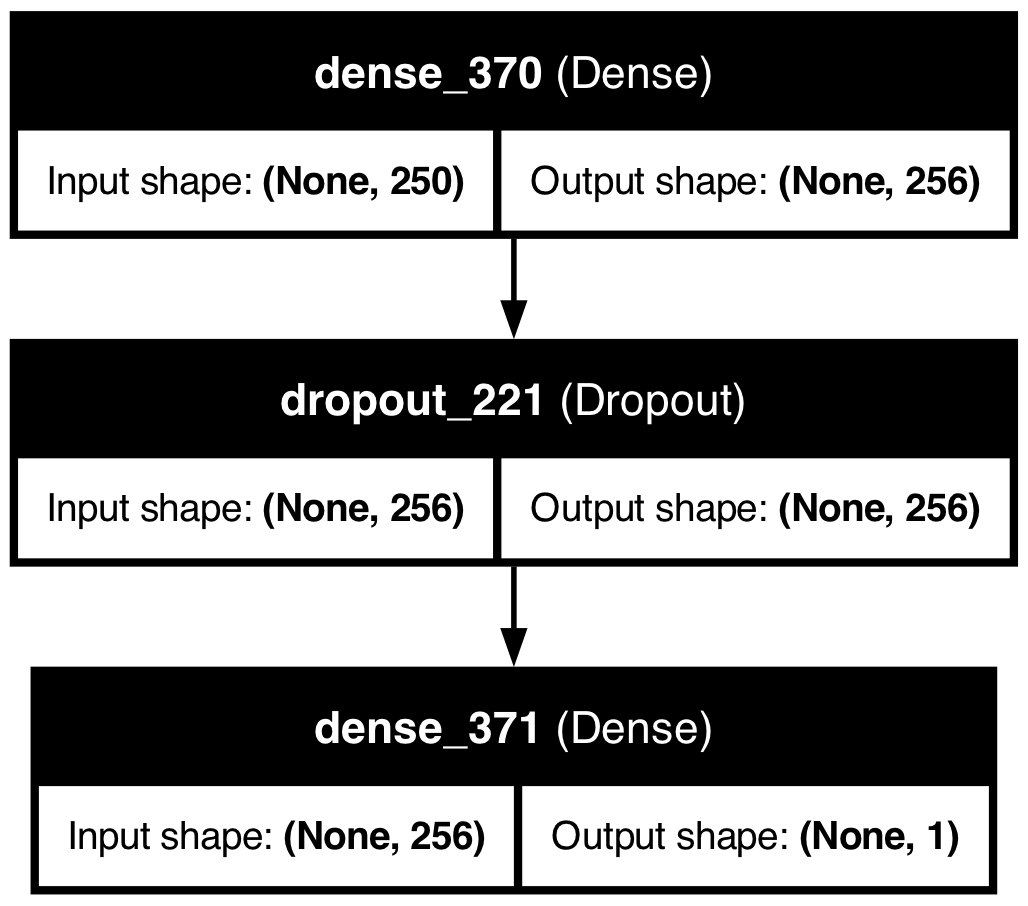

In [ ]:
# Generate the plot
plot_model(model_2cWV, show_shapes=True, show_layer_names=True)

Epoch 1/300


241/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5104 - loss: 0.6942
Epoch 1: val_loss improved from inf to 0.68295, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5109 - loss: 0.6941 - val_accuracy: 0.5402 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 2/300
229/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5556 - loss: 0.6836
Epoch 2: val_loss improved from 0.68295 to 0.67620, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5555 - loss: 0.6836 - val_accuracy: 0.5706 - val_loss: 0.6762 - learning_rate: 0.0010
Epoch 3/300
244/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5757 - loss: 0.6789
Epoch 3: val_loss improved from 0.67620 to 0.67096, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5759 - loss: 0.6788 - val_accuracy: 0.5503 - val_loss: 0.6710 - learning_rate: 0.0010
Epoch 4/300
244/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5897 - los

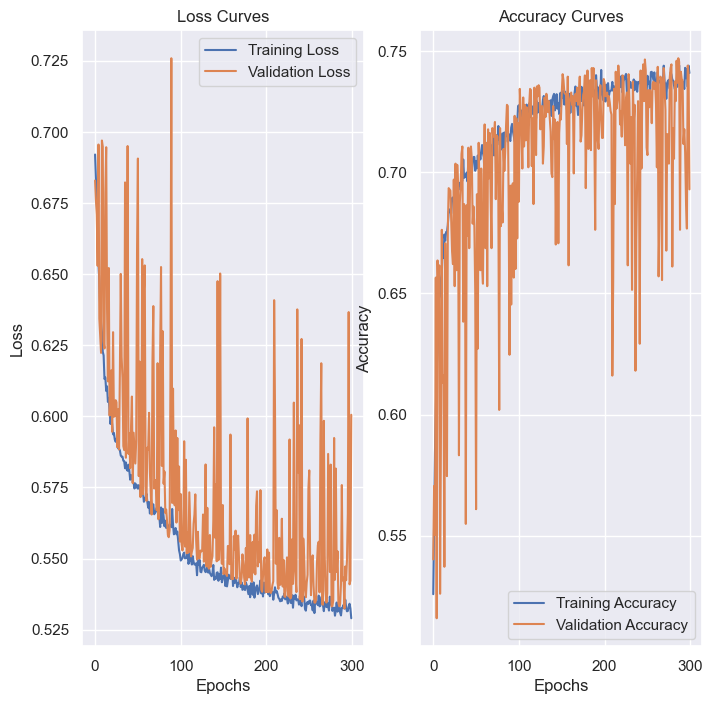

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=50, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2cWV_history = model_2cWV.fit(
    cX_train_vec, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with model's history
plot_loss_curves(model_2cWV_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_2cWV.predict(cX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2cWV_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m2cWV_accuracy = accuracy_score(cy_test, cy_pred)
m2cWV_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2cWV_recall = recall_score(cy_test, cy_pred, average='weighted')
m2cWV_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2cWV_accuracy:.2%}", f"{m2cWV_precision:.3f}", f"{m2cWV_recall:.3f}", f"{m2cWV_f1:.3f}", f"{m2cWV_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance          Results
         accuracy           75.24%
        precision            0.756
           recall            0.752
         f1_score            0.752
    time/instance 0.000273 seconds


In [ ]:
store_results('Model_2cWV', m2cWV_accuracy, m2cWV_precision, m2cWV_recall, m2cWV_f1, m2cWV_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.784  0.782    0.782  0.000265 seconds
3  Model_1rTI   79.37%     0.796  0.794    0.793  0.000257 seconds
4  Model_2cWV   75.24%     0.756  0.752    0.752  0.000273 seconds


#### FNN with raw data (Word2Vec)

In [ ]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.01):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_vec.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.01, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(rX_train_vec, ry_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5657 - loss: 0.6761
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6255 - loss: 0.6500
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6385 - loss: 0.6436
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6360 - loss: 0.6366
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6407 - loss: 0.6293
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6567 - loss: 0.6167
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6521 - loss: 0.6156
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6655 - loss: 0.6086
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6653 - loss: 0.6091
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6651 - loss: 0.6160
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6710 - loss: 0.6077
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5840 - loss: 0.6712
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6240 - loss: 0.6524
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6468 - loss: 0.6336
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6511 - loss: 0.6282
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6521 - loss: 0.6244
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6467 - loss: 0.6231
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6728 - loss: 0.6076
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6651 - loss: 0.6129
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6652 - loss: 0.6060
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6702 - loss: 0.6054
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6766 - loss: 0.6007
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5675 - loss: 0.6767
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6042 - loss: 0.6558
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6191 - loss: 0.6452
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.6242
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6432 - loss: 0.6265
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6443 - loss: 0.6209
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6744 - loss: 0.6147
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6603 - loss: 0.6069
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6600 - loss: 0.6010
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6743 - loss: 0.6021
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6793 - loss: 0.6028
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5726 - loss: 0.8039
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6122 - loss: 0.7130
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6174 - loss: 0.6884
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6217 - loss: 0.6792
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6283 - loss: 0.6658
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6081 - loss: 0.6693
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6214 - loss: 0.6637
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6334 - loss: 0.6581
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6400 - loss: 0.6507
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6259 - loss: 0.6576
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6380 - loss: 0.6542
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5682 - loss: 0.8120
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6121 - loss: 0.7130
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6124 - loss: 0.6893
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6264 - loss: 0.6744
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6313 - loss: 0.6682
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6418 - loss: 0.6637
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6380 - loss: 0.6586
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6302 - loss: 0.6653
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6462 - loss: 0.6493
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6345 - loss: 0.6519
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6444 - loss: 0.6492
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5659 - loss: 0.8070
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5980 - loss: 0.7142
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6248 - loss: 0.6890
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6153 - loss: 0.6761
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6233 - loss: 0.6677
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.6667
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6293 - loss: 0.6584
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6388 - loss: 0.6532
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6442 - loss: 0.6479
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6357 - loss: 0.6513
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6403 - loss: 0.6491
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5585 - loss: 0.6806
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6091 - loss: 0.6567
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 0.6411
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6435 - loss: 0.6318
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6429 - loss: 0.6315
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6490 - loss: 0.6199
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6707 - loss: 0.6099
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6681 - loss: 0.6092
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6744 - loss: 0.6080
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6745 - loss: 0.6019
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6764 - loss: 0.5971
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5589 - loss: 0.6790
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6232 - loss: 0.6500
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6263 - loss: 0.6442
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6391 - loss: 0.6307
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6482 - loss: 0.6288
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6622 - loss: 0.6142
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6681 - loss: 0.6054
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6623 - loss: 0.6173
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6650 - loss: 0.6106
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6639 - loss: 0.6026
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6844 - loss: 0.5920
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5814 - loss: 0.6758
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6208 - loss: 0.6545
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6248 - loss: 0.6384
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6384 - loss: 0.6310
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6520 - loss: 0.6185
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6538 - loss: 0.6138
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6647 - loss: 0.6143
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6785 - loss: 0.5989
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6581 - loss: 0.6078
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6711 - loss: 0.6014
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6733 - loss: 0.5968
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accurac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5676 - loss: 0.8633
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6264 - loss: 0.7241
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6102 - loss: 0.6951
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6135 - loss: 0.6817
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6151 - loss: 0.6793
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6381 - loss: 0.6632
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6328 - loss: 0.6680
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6308 - loss: 0.6591
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6298 - loss: 0.6635
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6396 - loss: 0.6550
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6371 - loss: 0.6538
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5587 - loss: 0.8683
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6029 - loss: 0.7333
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6212 - loss: 0.6974
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6281 - loss: 0.6787
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6156 - loss: 0.6796
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6310 - loss: 0.6675
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6204 - loss: 0.6692
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6404 - loss: 0.6615
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6353 - loss: 0.6593
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6445 - loss: 0.6566
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6463 - loss: 0.6506
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5641 - loss: 0.8765
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6063 - loss: 0.7397
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6254 - loss: 0.6973
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6222 - loss: 0.6843
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6294 - loss: 0.6768
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6324 - loss: 0.6666
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6361 - loss: 0.6609
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6463 - loss: 0.6596
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6436 - loss: 0.6554
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6351 - loss: 0.6490
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6430 - loss: 0.6505
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5707 - loss: 0.6740
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6256 - loss: 0.6456
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6282 - loss: 0.6446
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6423 - loss: 0.6303
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6534 - loss: 0.6178
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6453 - loss: 0.6231
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6621 - loss: 0.6111
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6728 - loss: 0.6041
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6609 - loss: 0.6140
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6771 - loss: 0.5984
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6704 - loss: 0.6043
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5793 - loss: 0.6722
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6399 - loss: 0.6429
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6318 - loss: 0.6377
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6434 - loss: 0.6279
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6536 - loss: 0.6206
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6554 - loss: 0.6192
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6686 - loss: 0.6175
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6657 - loss: 0.6099
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6726 - loss: 0.6090
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6767 - loss: 0.5997
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6723 - loss: 0.6043
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5741 - loss: 0.6714
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6270 - loss: 0.6440
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6423 - loss: 0.6340
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6437 - loss: 0.6279
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6472 - loss: 0.6198
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6613 - loss: 0.6145
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6535 - loss: 0.6164
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6750 - loss: 0.5975
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6699 - loss: 0.6036
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6731 - loss: 0.5941
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6818 - loss: 0.5930
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5727 - loss: 0.8590
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6106 - loss: 0.7228
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6171 - loss: 0.6898
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6300 - loss: 0.6772
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6196 - loss: 0.6746
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6174 - loss: 0.6691
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6306 - loss: 0.6645
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6325 - loss: 0.6594
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6286 - loss: 0.6589
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6383 - loss: 0.6493
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6277 - loss: 0.6543
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5812 - loss: 0.8568
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6114 - loss: 0.7207
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6179 - loss: 0.6905
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6319 - loss: 0.6732
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6408 - loss: 0.6607
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6226 - loss: 0.6618
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6259 - loss: 0.6637
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6378 - loss: 0.6602
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6398 - loss: 0.6465
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6198 - loss: 0.6568
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6460 - loss: 0.6480
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5581 - loss: 0.8620
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6141 - loss: 0.7171
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6162 - loss: 0.6917
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6273 - loss: 0.6694
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6238 - loss: 0.6664
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6420 - loss: 0.6569
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6481 - loss: 0.6527
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6251 - loss: 0.6590
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6424 - loss: 0.6514
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6348 - loss: 0.6485
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6387 - loss: 0.6511
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5698 - loss: 0.6741
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6216 - loss: 0.6548
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6418 - loss: 0.6387
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6416 - loss: 0.6268
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6486 - loss: 0.6206
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6506 - loss: 0.6244
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6563 - loss: 0.6138
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6594 - loss: 0.6159
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6713 - loss: 0.6069
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6639 - loss: 0.6039
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6709 - loss: 0.6015
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5676 - loss: 0.6750
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6157 - loss: 0.6577
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6302 - loss: 0.6369
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6511 - loss: 0.6211
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6584 - loss: 0.6152
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6517 - loss: 0.6226
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6508 - loss: 0.6197
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6679 - loss: 0.6027
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6717 - loss: 0.6054
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6801 - loss: 0.5985
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6771 - loss: 0.5928
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5578 - loss: 0.6780
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6117 - loss: 0.6568
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6439 - loss: 0.6324
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6500 - loss: 0.6261
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6620 - loss: 0.6124
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6560 - loss: 0.6055
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6647 - loss: 0.6113
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6735 - loss: 0.6034
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6618 - loss: 0.6107
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6667 - loss: 0.5977
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6757 - loss: 0.5997
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5651 - loss: 0.9702
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6167 - loss: 0.7328
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6119 - loss: 0.6965
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6207 - loss: 0.6762
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6285 - loss: 0.6726
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6397 - loss: 0.6593
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6254 - loss: 0.6673
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6276 - loss: 0.6562
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6340 - loss: 0.6631
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6345 - loss: 0.6544
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6369 - loss: 0.6505
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5664 - loss: 0.9737
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6035 - loss: 0.7470
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6253 - loss: 0.6944
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6285 - loss: 0.6754
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6291 - loss: 0.6699
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6353 - loss: 0.6658
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6303 - loss: 0.6594
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6284 - loss: 0.6658
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6248 - loss: 0.6623
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6441 - loss: 0.6528
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6386 - loss: 0.6539
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5723 - loss: 0.9755
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6135 - loss: 0.7479
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6116 - loss: 0.7025
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6308 - loss: 0.6799
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6237 - loss: 0.6757
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6276 - loss: 0.6674
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6328 - loss: 0.6616
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6288 - loss: 0.6643
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6343 - loss: 0.6558
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6457 - loss: 0.6538
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6309 - loss: 0.6604
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5212 - loss: 0.6929
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5879 - loss: 0.6745
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5910 - loss: 0.6670
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5963 - loss: 0.6606
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6046 - loss: 0.6609
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6127 - loss: 0.6575
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6132 - loss: 0.6563
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6254 - loss: 0.6521
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6197 - loss: 0.6507
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6397 - loss: 0.6437
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6301 - loss: 0.6473
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5284 - loss: 0.6888
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5921 - loss: 0.6722
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5990 - loss: 0.6638
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6134 - loss: 0.6600
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6142 - loss: 0.6563
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6182 - loss: 0.6558
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6210 - loss: 0.6515
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6347 - loss: 0.6496
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6241 - loss: 0.6521
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6258 - loss: 0.6523
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6350 - loss: 0.6428
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5412 - loss: 0.6876
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5861 - loss: 0.6722
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5839 - loss: 0.6693
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6102 - loss: 0.6601
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6022 - loss: 0.6555
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6152 - loss: 0.6489
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6165 - loss: 0.6529
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6417 - loss: 0.6457
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6331 - loss: 0.6460
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6327 - loss: 0.6451
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6379 - loss: 0.6432
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5314 - loss: 0.8523
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5792 - loss: 0.8147
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5985 - loss: 0.7877
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5992 - loss: 0.7727
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6101 - loss: 0.7577
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6107 - loss: 0.7480
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6116 - loss: 0.7389
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6159 - loss: 0.7268
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6206 - loss: 0.7220
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6139 - loss: 0.7174
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.7115
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5083 - loss: 0.8556
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5794 - loss: 0.8171
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5962 - loss: 0.7883
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6024 - loss: 0.7680
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6092 - loss: 0.7557
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6080 - loss: 0.7448
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6134 - loss: 0.7406
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6032 - loss: 0.7368
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6081 - loss: 0.7281
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6206 - loss: 0.7149
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6204 - loss: 0.7098
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5092 - loss: 0.8544
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5989 - loss: 0.8129
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6020 - loss: 0.7874
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6035 - loss: 0.7687
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6057 - loss: 0.7524
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5996 - loss: 0.7489
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6116 - loss: 0.7356
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6023 - loss: 0.7278
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6071 - loss: 0.7257
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6225 - loss: 0.7128
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6188 - loss: 0.7112
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5288 - loss: 0.6887
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5814 - loss: 0.6742
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5986 - loss: 0.6651
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6050 - loss: 0.6602
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6130 - loss: 0.6591
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6195 - loss: 0.6506
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6210 - loss: 0.6539
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6348 - loss: 0.6519
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6214 - loss: 0.6521
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6417 - loss: 0.6411
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6368 - loss: 0.6376
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5066 - loss: 0.6936
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5787 - loss: 0.6774
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6046 - loss: 0.6627
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6042 - loss: 0.6589
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6154 - loss: 0.6553
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6079 - loss: 0.6580
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6187 - loss: 0.6545
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6279 - loss: 0.6505
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6267 - loss: 0.6504
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6308 - loss: 0.6455
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6485 - loss: 0.6404
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5220 - loss: 0.6908
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5736 - loss: 0.6773
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5846 - loss: 0.6691
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5817 - loss: 0.6671
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6106 - loss: 0.6564
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6187 - loss: 0.6555
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5910 - loss: 0.6602
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6253 - loss: 0.6533
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6244 - loss: 0.6512
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6242 - loss: 0.6507
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6277 - loss: 0.6467
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5261 - loss: 0.9353
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5785 - loss: 0.8907
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5843 - loss: 0.8565
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6022 - loss: 0.8266
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6024 - loss: 0.8093
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6072 - loss: 0.7914
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6117 - loss: 0.7806
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6101 - loss: 0.7722
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6121 - loss: 0.7609
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6096 - loss: 0.7507
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6194 - loss: 0.7386
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5230 - loss: 0.9373
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5770 - loss: 0.8892
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5909 - loss: 0.8558
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5964 - loss: 0.8282
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6066 - loss: 0.8034
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6091 - loss: 0.7881
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6119 - loss: 0.7739
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6316 - loss: 0.7550
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6203 - loss: 0.7532
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6224 - loss: 0.7441
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6242 - loss: 0.7376
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5042 - loss: 0.9375
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5701 - loss: 0.8929
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6066 - loss: 0.8534
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5907 - loss: 0.8267
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6050 - loss: 0.8078
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6171 - loss: 0.7864
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.7723
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6147 - loss: 0.7640
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6083 - loss: 0.7558
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6264 - loss: 0.7442
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6244 - loss: 0.7364
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5424 - loss: 0.6874
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5807 - loss: 0.6688
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6094 - loss: 0.6571
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6097 - loss: 0.6561
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6186 - loss: 0.6530
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6099 - loss: 0.6531
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6192 - loss: 0.6516
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6242 - loss: 0.6518
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6290 - loss: 0.6476
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6431 - loss: 0.6432
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6385 - loss: 0.6452
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5469 - loss: 0.6853
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6060 - loss: 0.6660
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6021 - loss: 0.6632
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6061 - loss: 0.6590
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6158 - loss: 0.6552
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6259 - loss: 0.6506
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6258 - loss: 0.6522
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6367 - loss: 0.6438
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6304 - loss: 0.6451
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6387 - loss: 0.6397
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6395 - loss: 0.6412
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5427 - loss: 0.6879
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5971 - loss: 0.6630
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6070 - loss: 0.6600
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6129 - loss: 0.6520
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6067 - loss: 0.6571
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6253 - loss: 0.6545
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6158 - loss: 0.6537
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6347 - loss: 0.6446
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6347 - loss: 0.6450
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6323 - loss: 0.6420
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6324 - loss: 0.6447
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5540 - loss: 0.9284
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5874 - loss: 0.8714
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6085 - loss: 0.8292
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6056 - loss: 0.8014
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6124 - loss: 0.7845
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6135 - loss: 0.7673
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6369 - loss: 0.7517
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6107 - loss: 0.7469
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6238 - loss: 0.7312
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6291 - loss: 0.7230
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6216 - loss: 0.7183
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5544 - loss: 0.9278
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5941 - loss: 0.8713
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6246 - loss: 0.8258
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6101 - loss: 0.8064
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6111 - loss: 0.7836
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6157 - loss: 0.7656
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6185 - loss: 0.7553
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6335 - loss: 0.7414
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6379 - loss: 0.7270
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6192 - loss: 0.7269
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6300 - loss: 0.7183
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5496 - loss: 0.9298
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5910 - loss: 0.8718
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6000 - loss: 0.8322
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5931 - loss: 0.8100
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6100 - loss: 0.7842
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6127 - loss: 0.7667
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6203 - loss: 0.7527
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6354 - loss: 0.7386
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6200 - loss: 0.7356
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6205 - loss: 0.7321
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6171 - loss: 0.7238
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5276 - loss: 0.6906
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5918 - loss: 0.6711
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6082 - loss: 0.6620
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6128 - loss: 0.6558
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6118 - loss: 0.6577
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6184 - loss: 0.6534
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6379 - loss: 0.6417
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6287 - loss: 0.6492
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6337 - loss: 0.6417
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6477 - loss: 0.6350
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6447 - loss: 0.6323
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5401 - loss: 0.6885
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5869 - loss: 0.6711
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6119 - loss: 0.6545
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6186 - loss: 0.6531
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6177 - loss: 0.6588
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6295 - loss: 0.6498
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6234 - loss: 0.6533
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6390 - loss: 0.6391
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6566 - loss: 0.6354
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6426 - loss: 0.6314
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6558 - loss: 0.6320
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5452 - loss: 0.6859
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5991 - loss: 0.6650
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6029 - loss: 0.6592
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6213 - loss: 0.6535
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6200 - loss: 0.6510
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6311 - loss: 0.6448
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6336 - loss: 0.6470
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6306 - loss: 0.6408
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6475 - loss: 0.6303
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6499 - loss: 0.6319
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6421 - loss: 0.6303
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5386 - loss: 1.0933
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5766 - loss: 1.0047
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5982 - loss: 0.9419
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6186 - loss: 0.8941
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6145 - loss: 0.8642
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6231 - loss: 0.8308
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6191 - loss: 0.8099
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6184 - loss: 0.7943
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6307 - loss: 0.7741
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6289 - loss: 0.7637
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6319 - loss: 0.7519
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5463 - loss: 1.0908
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5743 - loss: 1.0021
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6009 - loss: 0.9376
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6051 - loss: 0.8909
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6251 - loss: 0.8482
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6157 - loss: 0.8227
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6365 - loss: 0.7943
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6273 - loss: 0.7836
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6311 - loss: 0.7675
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6372 - loss: 0.7560
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6360 - loss: 0.7405
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5271 - loss: 1.0943
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5874 - loss: 1.0012
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5991 - loss: 0.9338
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6156 - loss: 0.8839
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5984 - loss: 0.8592
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6148 - loss: 0.8250
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6165 - loss: 0.8037
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6314 - loss: 0.7799
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6199 - loss: 0.7725
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6254 - loss: 0.7585
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6259 - loss: 0.7473
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5722 - loss: 0.6736
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6379 - loss: 0.6397
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6445 - loss: 0.6264
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6564 - loss: 0.6126
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6707 - loss: 0.6097
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6614 - loss: 0.6054
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6821 - loss: 0.6039
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6770 - loss: 0.5995
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6804 - loss: 0.5934
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6837 - loss: 0.5938
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6800 - loss: 0.5962
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

In [ ]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.712465 using {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.697085 (0.011963) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.669364 (0.007855) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.706799 (0.002411) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.688487 (0.008561) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.712262 (0.000470) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.644778 (0.016837) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.712465 (0.004116) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.678876 (0.009874) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.662485 (0.001388) with: {'learning_rate': 

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_2rWV = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_2rWV.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_495 (Dense)               │ (None, 256)            │        64,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_296 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_496 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_297 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_497 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,281 (380.00 KB)

 Trainable params: 97,281 (380.00 KB)

 Non-trainable params: 0 (0.00 B)

None


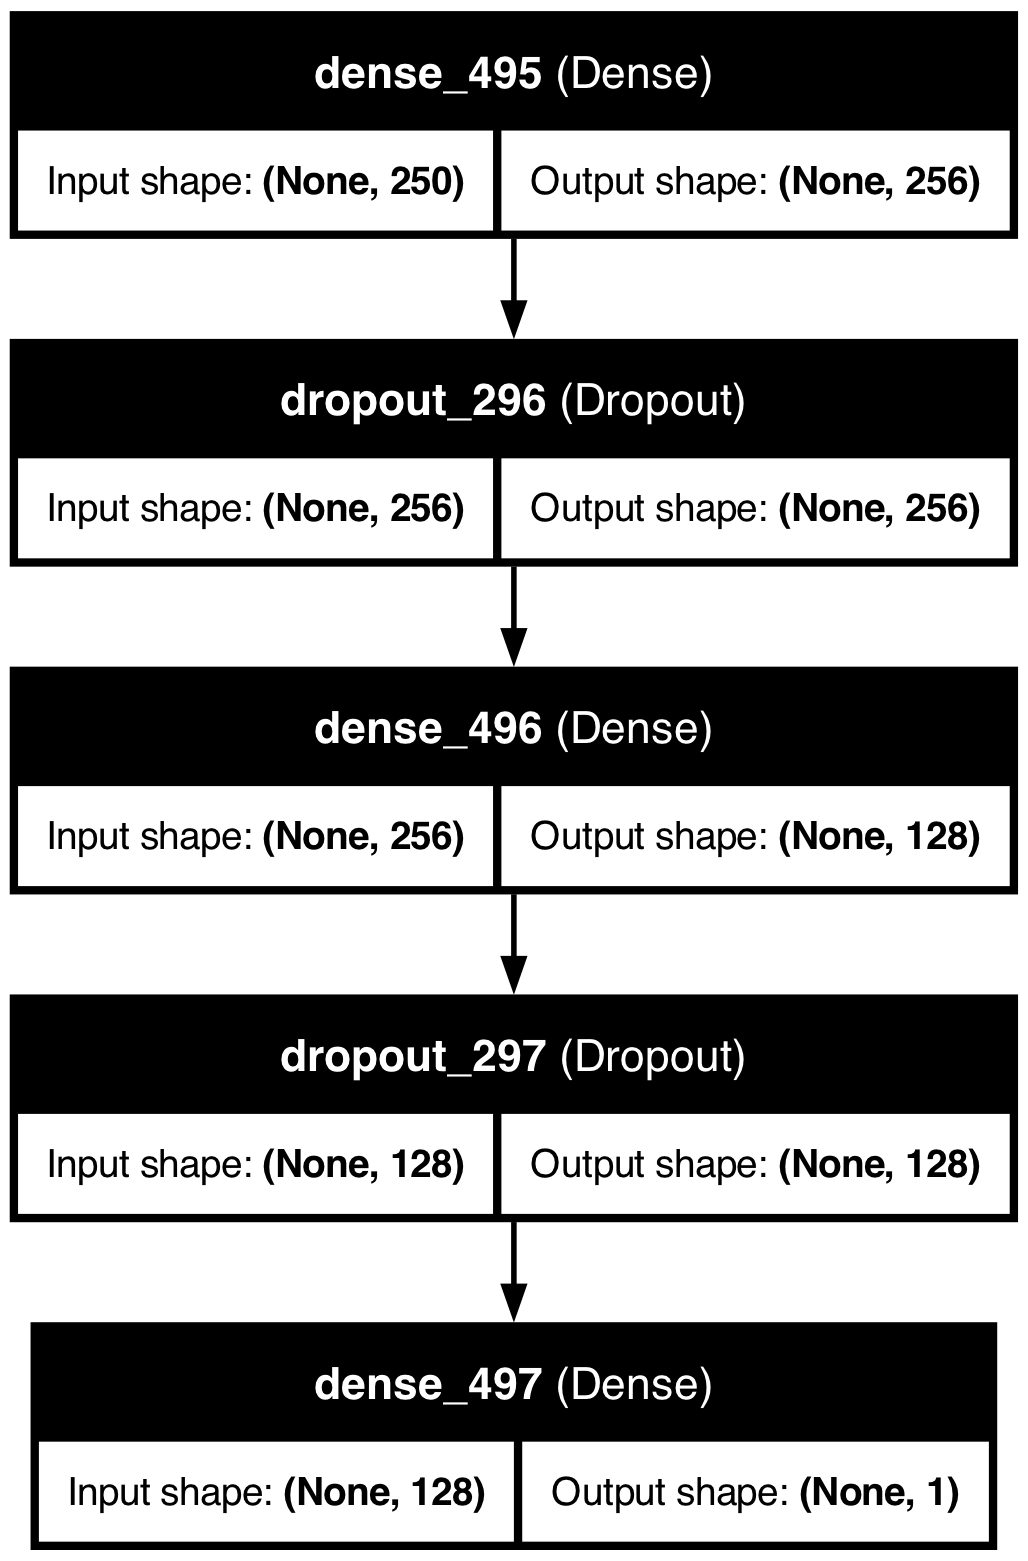

In [ ]:
# Generate the plot
plot_model(model_2rWV, show_shapes=True, show_layer_names=True)

Epoch 1/300
230/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5847 - loss: 0.6725
Epoch 1: val_loss improved from inf to 0.64401, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5861 - loss: 0.6718 - val_accuracy: 0.6449 - val_loss: 0.6440 - learning_rate: 0.0010
Epoch 2/300
231/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6286 - loss: 0.6484
Epoch 2: val_loss improved from 0.64401 to 0.62446, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6285 - loss: 0.6481 - val_accuracy: 0.6540 - val_loss: 0.6245 - learning_rate: 0.0010
Epoch 3/300
241/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6521 - loss: 0.6259
Epoch 3: val_loss improved from 0.62446 to 0.61214, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6519 - loss: 0.6260 - val_accuracy: 0.6606 - val_loss: 0.6121 - learning_rate: 0.0010
Epoch 4/300
244/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 

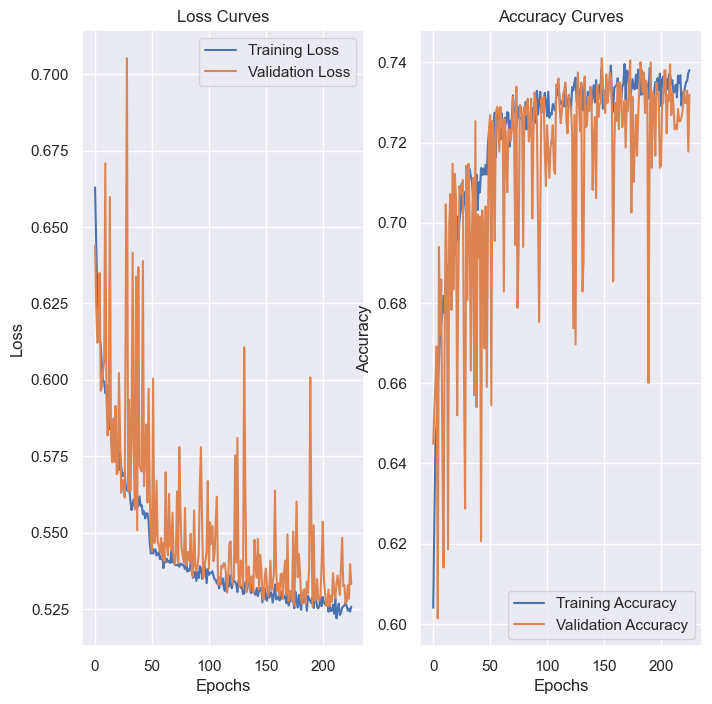

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=50, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2rWV_history = model_2rWV.fit(
    rX_train_vec, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with model's history
plot_loss_curves(model_2rWV_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_2rWV.predict(rX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2rWV_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m2rWV_accuracy = accuracy_score(ry_test, ry_pred)
m2rWV_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2rWV_recall = recall_score(ry_test, ry_pred, average='weighted')
m2rWV_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2rWV_accuracy:.2%}", f"{m2rWV_precision:.3f}", f"{m2rWV_recall:.3f}", f"{m2rWV_f1:.3f}", f"{m2rWV_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Model Performance          Results
         accuracy           73.42%
        precision            0.739
           recall            0.734
         f1_score            0.733
    time/instance 0.000915 seconds


In [ ]:
store_results('Model_2rWV', m2rWV_accuracy, m2rWV_precision, m2rWV_recall, m2rWV_f1, m2rWV_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.784  0.782    0.782  0.000265 seconds
3  Model_1rTI   79.37%     0.796  0.794    0.793  0.000257 seconds
4  Model_2cWV   75.24%     0.756  0.752    0.752  0.000273 seconds
5  Model_2rWV   73.42%     0.739  0.734    0.733  0.000915 seconds


### LSTM (single layer)

My second model is a LSTM with a single layer and since TF-IDF is better we will continue with this vectorization

#### LSTM reshaping 

In [ ]:
# Convert sparse TF-IDF data to dense arrays and then reshape for LSTM
cX_train_lstm = cX_train_tfidf.toarray().reshape(cX_train_tfidf.shape[0], 1, cX_train_tfidf.shape[1])
cX_test_lstm = cX_test_tfidf.toarray().reshape(cX_test_tfidf.shape[0], 1, cX_test_tfidf.shape[1])

rX_train_lstm = rX_train_tfidf.toarray().reshape(rX_train_tfidf.shape[0], 1, rX_train_tfidf.shape[1])
rX_test_lstm = rX_test_tfidf.toarray().reshape(rX_test_tfidf.shape[0], 1, rX_test_tfidf.shape[1])

In [ ]:
print(cX_train_lstm.shape)

(9884, 1, 6695)


#### LSTM (single layer) with cleaned data

In [ ]:
# Define the LSTM model
def create_model(lstm_units=128, learning_rate=0.001, dropout_rate=0.3, regularization=0.01):
    model = Sequential()
    model.add(LSTM(units=lstm_units, input_shape=(cX_train_lstm.shape[1], cX_train_lstm.shape[2]), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, lstm_units=128, learning_rate=0.001, dropout_rate=0.3, regularization=0.01, epochs=30, batch_size=32, verbose=1)

# Define the grid search parameters
param_grid = {
    'lstm_units': [128, 256],  # Focused values for LSTM units
    'learning_rate': [0.001, 0.0001],  # Narrow range for learning rate
    'dropout_rate': [0.3, 0.5],  # Focused range for dropout rate
    'regularization': [0, 0.001],  # Focused regularization strengths
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(cX_train_lstm, cy_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_2cIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_2cIT.summary())

In [ ]:
# Generate the plot
plot_model(model_2cIT, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2cIT_history = model_2cIT.fit(
    cX_train_lstm, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

In [ ]:
# Use the function with your model's history
plot_loss_curves(model_2cIT_history) 

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_2cIT.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2cIT_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m2cIT_accuracy = accuracy_score(cy_test, cy_pred)
m2cIT_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2cIT_recall = recall_score(cy_test, cy_pred, average='weighted')
m2cIT_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2cIT_accuracy:.2%}", f"{m2cIT_precision:.3f}", f"{m2cIT_recall:.3f}", f"{m2cIT_f1:.3f}", f"{m2cIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_2cIT', m2cIT_accuracy, m2cIT_precision, m2cIT_recall, m2cIT_f1, m2cIT_time_per_instance)

# View the consolidated results
print(results_df)

#### LSTM (single layer) with raw data

In [ ]:
# Define the LSTM model
def create_model(lstm_units=128, learning_rate=0.001, dropout_rate=0.3, regularization=0.01):
    model = Sequential()
    model.add(LSTM(units=lstm_units, input_shape=(rX_train_lstm.shape[1], rX_train_lstm.shape[2]), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, lstm_units=128, learning_rate=0.001, dropout_rate=0.3, regularization=0.01, epochs=30, batch_size=32, verbose=1)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(rX_train_lstm, ry_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [40]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_2rIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_2rIT.summary())

In [ ]:
# Generate the plot
plot_model(model_2rIT, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2rIT_history = model_2rIT.fit(
    rX_train_lstm, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_2rIT_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_2rIT.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2rIT_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m2rIT_accuracy = accuracy_score(ry_test, ry_pred)
m2rIT_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2rIT_recall = recall_score(ry_test, ry_pred, average='weighted')
m2rIT_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2rIT_accuracy:.2%}", f"{m2rIT_precision:.3f}", f"{m2rIT_recall:.3f}", f"{m2rIT_f1:.3f}", f"{m2rIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_2rIT', m2rIT_accuracy, m2rIT_precision, m2rIT_recall, m2rIT_f1, m2rIT_time_per_instance)

# View the consolidated results
print(results_df)

### LSTM (stacked)

Now I use another LSTM (LSTM stacked)

#### LSTM (stacked) with cleaned data

In [47]:
# Define the Stacked LSTM model
def create_model(lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2):
    model = Sequential()
    for i in range(num_layers - 1):
        model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(cX_train_lstm.shape[1], cX_train_lstm.shape[2])))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model,lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Define the reduced grid search parameters
param_grid = {
    'lstm_units': [128, 256],  # Focused values for LSTM units
    'learning_rate': [0.001, 0.0001],  # Narrow range for learning rate
    'dropout_rate': [0.3, 0.5],  # Focused range for dropout rate
    'num_layers': [2, 3]  # Number of stacked LSTM layers
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Fit the grid search
grid_result = grid.fit(cX_train_lstm, cy_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [51]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_3cIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    num_layers=best_params['num_layers']
)

# Model Summary
print(model_3cIT.summary())

In [ ]:
# Generate the plot
plot_model(model_3cIT, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_3cIT_history = model_3cIT.fit(
    cX_train_lstm, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

In [ ]:
# Use the function with the model's history
plot_loss_curves(model_3cIT_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_3cIT.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3cIT_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m3cIT_accuracy = accuracy_score(cy_test, cy_pred)
m3cIT_precision = precision_score(cy_test, cy_pred, average='weighted')
m3cIT_recall = recall_score(cy_test, cy_pred, average='weighted')
m3cIT_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3cIT_accuracy:.2%}", f"{m3cIT_precision:.3f}", f"{m3cIT_recall:.3f}", f"{m3cIT_f1:.3f}", f"{m3cIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_3cIT', m3cIT_accuracy, m3cIT_precision, m3cIT_recall, m3cIT_f1, m3cIT_time_per_instance)

# View the consolidated results
print(results_df)

#### LSTM (stacked) with raw data

In [59]:
# Define the Stacked LSTM model
def create_model(lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2):
    model = Sequential()
    for i in range(num_layers - 1):
        model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(rX_train_lstm.shape[1], rX_train_lstm.shape[2])))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model,lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Define the reduced grid search parameters
param_grid = {
    'lstm_units': [128, 256],  # Focused values for LSTM units
    'learning_rate': [0.001, 0.0001],  # Narrow range for learning rate
    'dropout_rate': [0.3, 0.5],  # Focused range for dropout rate
    'num_layers': [2, 3]  # Number of stacked LSTM layers
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Fit the grid search
grid_result = grid.fit(rX_train_lstm, ry_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [62]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_3rIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    num_layers=best_params['num_layers']
)

# Model Summary
print(model_3rIT.summary())

In [ ]:
# Generate the plot
plot_model(model_3rIT, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_3rIT_history = model_3rIT.fit(
    rX_train_lstm, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_3rIT_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_3rIT.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3rIT_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m3rIT_accuracy = accuracy_score(ry_test, ry_pred)
m3rIT_precision = precision_score(ry_test, ry_pred, average='weighted')
m3rIT_recall = recall_score(ry_test, ry_pred, average='weighted')
m3rIT_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3rIT_accuracy:.2%}", f"{m3rIT_precision:.3f}", f"{m3rIT_recall:.3f}", f"{m3rIT_f1:.3f}", f"{m3rIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_3rIT', m3rIT_accuracy, m3rIT_precision, m3rIT_recall, m3rIT_f1, m3rIT_time_per_instance)

# View the consolidated results
print(results_df)

### USE (Universal Sentence Encoder)

In [ ]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

#### USE with clean data (trainable and not trainable)

We will start with the trainable version

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=True)

# Precompute the embeddings for the training and test sets
cX_train_embeddings = USE_embedding(cX_train)
cX_test_embeddings = USE_embedding(cX_test)

In [ ]:
# Define the Stacked LSTM model with USE embeddings
def create_model(lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2):
    model = Sequential()
    for i in range(num_layers - 1):
        model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(cX_train_embeddings.shape[1], 1)))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model,lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Define the reduced grid search parameters
param_grid = {
    'lstm_units': [128, 256],  # Focused values for LSTM units
    'learning_rate': [0.001, 0.0001],  # Narrow range for learning rate
    'dropout_rate': [0.3, 0.5],  # Focused range for dropout rate
    'num_layers': [2, 3]  # Number of stacked LSTM layers
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(cX_train_embeddings, cy_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_4cUST = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    num_layers=best_params['num_layers']
)

# Model Summary
print(model_4cUST.summary())

In [ ]:
# Generate the plot
plot_model(model_4cUST, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4cUST_history = model_4cUST.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4cUST_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_4cUST.predict(cX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4cUST_time_per_instance = (end_time - start_time) / len(cX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4cUST_accuracy = accuracy_score(cy_test, cy_pred)
m4cUST_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4cUST_recall = recall_score(cy_test, cy_pred, average='weighted')
m4cUST_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4cUST_accuracy:.2%}", f"{m4cUST_precision:.3f}", f"{m4cUST_recall:.3f}", f"{m4cUST_f1:.3f}", f"{m4cUST_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_4cUST', m4cUST_accuracy, m4cUST_precision, m4cUST_recall, m4cUST_f1, m4cUST_time_per_instance)

# View the consolidated results
print(results_df)

Now the non-trainable version

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

# Precompute the embeddings for the training and test sets
cX_train_embeddings = USE_embedding(cX_train)
cX_test_embeddings = USE_embedding(cX_test)

In [ ]:
# Define the Stacked LSTM model with USE embeddings
def create_model(lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2):
    model = Sequential()
    for i in range(num_layers - 1):
        model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(cX_train_embeddings.shape[1], 1)))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model,lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Define the reduced grid search parameters
param_grid = {
    'lstm_units': [128, 256],  # Focused values for LSTM units
    'learning_rate': [0.001, 0.0001],  # Narrow range for learning rate
    'dropout_rate': [0.3, 0.5],  # Focused range for dropout rate
    'num_layers': [2, 3]  # Number of stacked LSTM layers
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(cX_train_embeddings, cy_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_4cUSF = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    num_layers=best_params['num_layers']
)

# Model Summary
print(model_4cUSF.summary())

In [ ]:
# Generate the plot
plot_model(model_4cUSF, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4cUSF_history = model_4cUSF.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4cUSF_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_4cUSF.predict(cX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4cUSF_time_per_instance = (end_time - start_time) / len(cX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4cUSF_accuracy = accuracy_score(cy_test, cy_pred)
m4cUSF_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4cUSF_recall = recall_score(cy_test, cy_pred, average='weighted')
m4cUSF_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4cUSF_accuracy:.2%}", f"{m4cUSF_precision:.3f}", f"{m4cUSF_recall:.3f}", f"{m4cUSF_f1:.3f}", f"{m4cUSF_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_4cUSF', m4cUSF_accuracy, m4cUSF_precision, m4cUSF_recall, m4cUSF_f1, m4cUSF_time_per_instance)

# View the consolidated results
print(results_df)

#### USE with raw data (trainable and not trainable)

We will start with the trainable version

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=True)

# Precompute the embeddings for the training and test sets
rX_train_embeddings = USE_embedding(rX_train)
rX_test_embeddings = USE_embedding(rX_test)

In [ ]:
# Define the Stacked LSTM model with USE embeddings
def create_model(lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2):
    model = Sequential()
    for i in range(num_layers - 1):
        model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(rX_train_embeddings.shape[1], 1)))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model,lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Define the reduced grid search parameters
param_grid = {
    'lstm_units': [128, 256],  # Focused values for LSTM units
    'learning_rate': [0.001, 0.0001],  # Narrow range for learning rate
    'dropout_rate': [0.3, 0.5],  # Focused range for dropout rate
    'num_layers': [2, 3]  # Number of stacked LSTM layers
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(rX_train_embeddings, ry_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_4rUST = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    num_layers=best_params['num_layers']
)

# Model Summary
print(model_4rUST.summary())

In [ ]:
# Generate the plot
plot_model(model_4rUST, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4rUST_history = model_4rUST.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4rUST_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_4rUST.predict(rX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4rUSF_time_per_instance = (end_time - start_time) / len(rX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4rUSF_accuracy = accuracy_score(ry_test, ry_pred)
m4rUSF_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4rUSF_recall = recall_score(ry_test, ry_pred, average='weighted')
m4rUSF_f1 = f1_score(ry_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4rUSF_accuracy:.2%}", f"{m4rUSF_precision:.3f}", f"{m4rUSF_recall:.3f}", f"{m4rUSF_f1:.3f}", f"{m4rUSF_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_4rUSF', m4rUSF_accuracy, m4rUSF_precision, m4rUSF_recall, m4rUSF_f1, m4rUSF_time_per_instance)

# View the consolidated results
print(results_df)

Now the non-trainable version

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

# Precompute the embeddings for the training and test sets
rX_train_embeddings = USE_embedding(rX_train)
rX_test_embeddings = USE_embedding(rX_test)

In [ ]:
# Define the Stacked LSTM model with USE embeddings
def create_model(lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2):
    model = Sequential()
    for i in range(num_layers - 1):
        model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(rX_train_embeddings.shape[1], 1)))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model,lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Define the reduced grid search parameters
param_grid = {
    'lstm_units': [128, 256],  # Focused values for LSTM units
    'learning_rate': [0.001, 0.0001],  # Narrow range for learning rate
    'dropout_rate': [0.3, 0.5],  # Focused range for dropout rate
    'num_layers': [2, 3]  # Number of stacked LSTM layers
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(rX_train_embeddings, ry_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_4rUSF = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    num_layers=best_params['num_layers']
)

# Model Summary
print(model_4rUSF.summary())

In [ ]:
# Generate the plot
plot_model(model_4rUSF, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4rUSF_history = model_4rUSF.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4rUSF_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_4rUSF.predict(rX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4rUSF_time_per_instance = (end_time - start_time) / len(rX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4rUSF_accuracy = accuracy_score(ry_test, ry_pred)
m4rUSF_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4rUSF_recall = recall_score(ry_test, ry_pred, average='weighted')
m4rUSF_f1 = f1_score(ry_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4rUSF_accuracy:.2%}", f"{m4rUSF_precision:.3f}", f"{m4rUSF_recall:.3f}", f"{m4rUSF_f1:.3f}", f"{m4rUSF_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_4rUSF', m4rUSF_accuracy, m4rUSF_precision, m4rUSF_recall, m4rUSF_f1, m4rUSF_time_per_instance)

# View the consolidated results
print(results_df)


### USE (Universal Sentence Encoder) (old version)

Here I will use the universal encoder from Google (USE)

#### USE with cleaned data

In [ ]:
# Define the model
model_4c = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddings.shape[1],)),
    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
model_4c.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

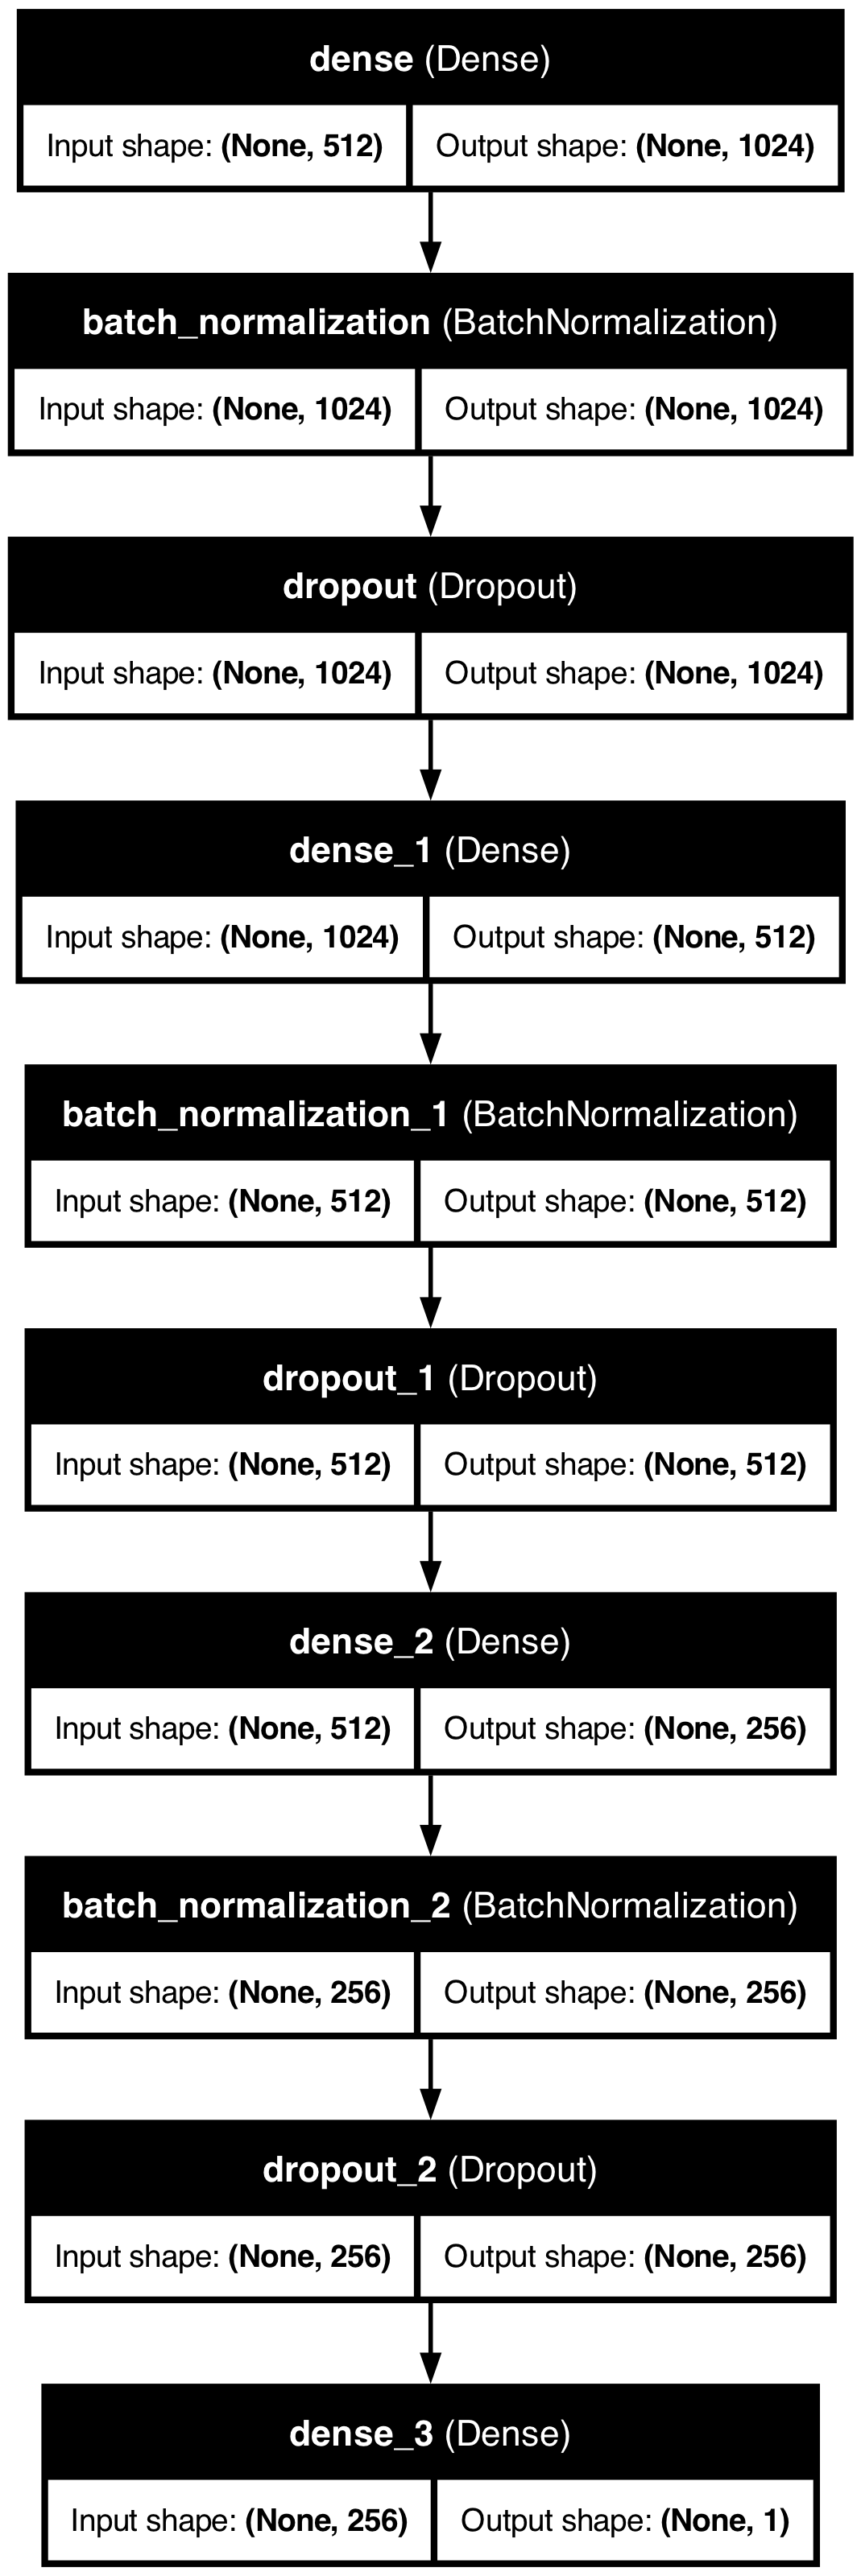

In [ ]:
# Generate the plot
plot_model(model_4c, show_shapes=True, show_layer_names=True)

In [ ]:
# Callback for early stopping
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
epochs = 300

# Fit the model
model_4c_history = model_4c.fit(
    cX_train_embeddings, 
    cy_train, 
    batch_size=64, 
    epochs=epochs, 
    validation_split=0.2, 
    callbacks=[callback_es]
)

# Model Summary
print(model_4c.summary())

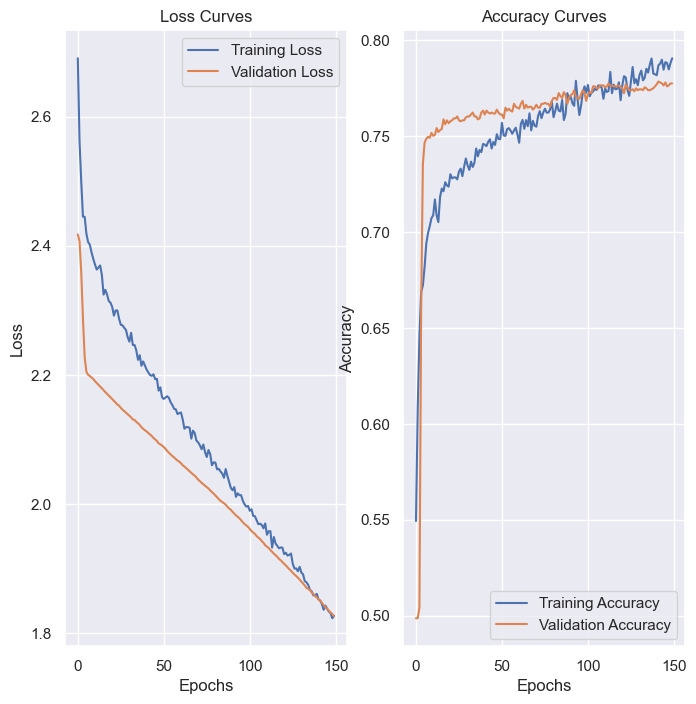

In [ ]:
# Use the function with your model's history
plot_loss_curves(model_4c_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_4c.predict(cX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4c_time_per_instance = (end_time - start_time) / len(cX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4c_accuracy = accuracy_score(cy_test, cy_pred)
m4c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4c_recall = recall_score(cy_test, cy_pred, average='weighted')
m4c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4c_accuracy:.2%}", f"{m4c_precision:.3f}", f"{m4c_recall:.3f}", f"{m4c_f1:.3f}", f"{m4c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Model Performance          Results
         accuracy           77.91%
        precision            0.779
           recall            0.779
         f1_score            0.779
    time/instance 0.000591 seconds


In [ ]:
#store_results('Model_4c', m4c_accuracy, m4c_precision, m4c_recall, m4c_f1, m4c_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000004 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   70.79%     0.712  0.708    0.706  0.000130 seconds
3   Model_1r   60.40%     0.616  0.604    0.593  0.000116 seconds
4   Model_1r   61.77%     0.622  0.618    0.615  0.000137 seconds
5   Model_1r   71.08%     0.712  0.711    0.710  0.000191 seconds
6   Model_1c   71.93%     0.723  0.719    0.718  0.000129 seconds
7   Model_1r   60.44%     0.605  0.604    0.604  0.000211 seconds
8   Model_1c   71.80%     0.721  0.718    0.717  0.000108 seconds
9   Model_1r   60.52%     0.610  0.605    0.601  0.000090 seconds
10  Model_1c   72.25%     0.727  0.722    0.721  0.000170 seconds
11  Model_1r   60.15%     0.602  0.602    0.602  0.000139 seconds
12  Model_1c   72.33%     0.729  0.723    0.722  0.000169 seconds
13  Model_1r   70.75%     0.715  0.708    0.705  0.000131 seconds
14  Model_

#### USE with raw data

In [ ]:
# Define the model
model_4r = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(rX_train_embeddings.shape[1],)),
    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# Using an optimizer with adaptive learning rate
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
model_4r.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])

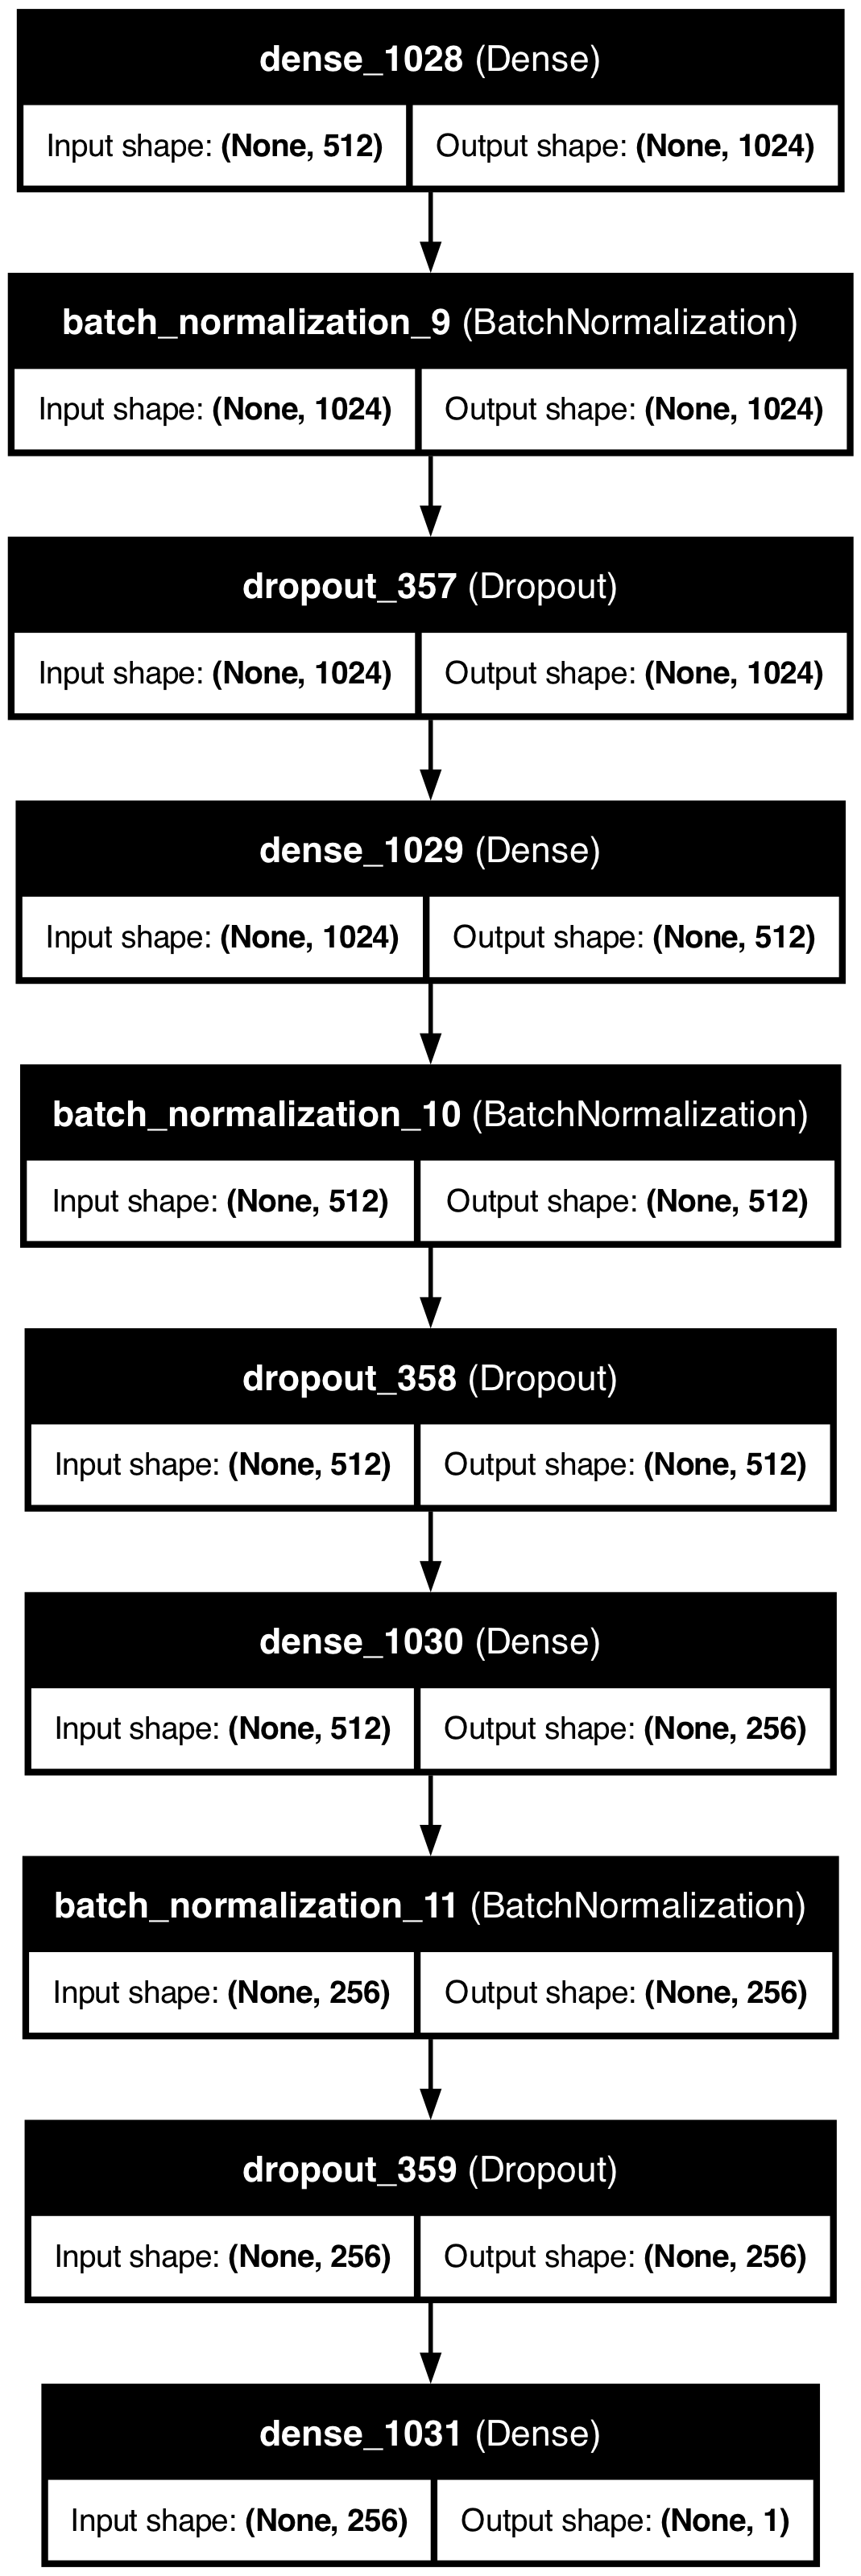

In [ ]:
# Generate the plot
plot_model(model_4r, show_shapes=True, show_layer_names=True)

In [ ]:
# Fit the model
model_4r_history = model_4r.fit(
    rX_train_embeddings, 
    ry_train, 
    batch_size=64, 
    epochs=epochs, 
    validation_split=0.2, 
    callbacks=[callback_es]
)

# Model Summary
print(model_4r.summary())

Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.5303 - loss: 2.7131 - val_accuracy: 0.6889 - val_loss: 2.3888
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5912 - loss: 2.5780 - val_accuracy: 0.7329 - val_loss: 2.3604
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6432 - loss: 2.4692 - val_accuracy: 0.7461 - val_loss: 2.3098
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6734 - loss: 2.4288 - val_accuracy: 0.7582 - val_loss: 2.2425
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6663 - loss: 2.4359 - val_accuracy: 0.7658 - val_loss: 2.1859
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6874 - loss: 2.4056 - val_accuracy: 0.7719 - val_loss: 2.1627
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7024 - loss: 2.3699 - val_accuracy: 0.7754 - val_loss: 2.1576
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6986 - loss: 2.3776 -

Model: "sequential_347"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1028 (Dense)              │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_357 (Dropout)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1029 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_358 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1030 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_359 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1031 (Dense)              │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,559,429 (13.58 MB)

 Trainable params: 1,185,281 (4.52 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 2,370,564 (9.04 MB)

None


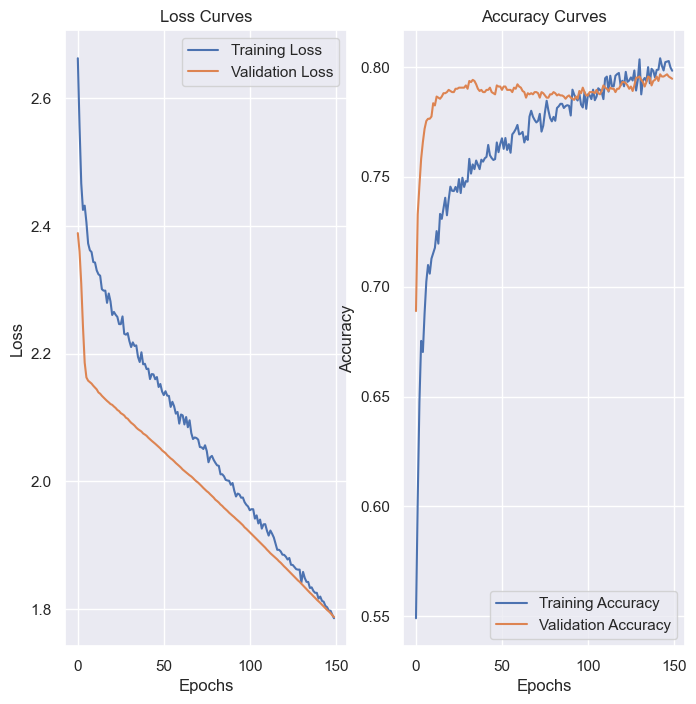

In [ ]:
# Use the function with your model's history
plot_loss_curves(model_4r_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_4r.predict(rX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4r_time_per_instance = (end_time - start_time) / len(rX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4r_accuracy = accuracy_score(ry_test, ry_pred)
m4r_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4r_recall = recall_score(ry_test, ry_pred, average='weighted')
m4r_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4r_accuracy:.2%}", f"{m4r_precision:.3f}", f"{m4r_recall:.3f}", f"{m4r_f1:.3f}", f"{m4r_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Model Performance          Results
         accuracy           79.13%
        precision            0.793
           recall            0.791
         f1_score            0.791
    time/instance 0.000839 seconds


In [ ]:
#store_results('Model_4r', m4r_accuracy, m4r_precision, m4r_recall, m4r_f1, m4r_time_per_instance)

# View the consolidated results
print(results_df)

## Model not use

### DistilBERT

In [ ]:
# from transformers import DistilBertTokenizer, TFDistilBertModel

In [ ]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
#def get_distilbert_embeddings(texts):
#    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=512)
#    outputs = distilbert_model(encoded_inputs)
#    # Take the mean of the output embeddings to use as sentence embeddings
#    return tf.reduce_mean(outputs.last_hidden_state, axis=1)

In [ ]:
# Convert texts to embeddings
#cX_train_embeddingsDBert = get_distilbert_embeddings(cX_train.tolist())
#cX_test_embeddingsDBert = get_distilbert_embeddings(cX_test.tolist())
#rX_train_embeddingsDBert = get_distilbert_embeddings(rX_train.tolist())
#rX_test_embeddingsDBert = get_distilbert_embeddings(rX_test.tolist())

: 

In [ ]:
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsDBert.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerDB = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerDB, loss='binary_crossentropy', metrics=['accuracy'])

# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Train the model
#model_history = model.fit(
#    cX_train_embeddingsDBert, 
#    ry_train, 
#    batch_size=32, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [ ]:
# Use the function with model's history
# plot_loss_curves(model_history)

### RoBERTa

In [ ]:
#from transformers import RobertaTokenizer, TFRobertaModel
#from tensorflow.keras.models import Model

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
#def get_roberta_embeddings(texts):
#    # Tokenize the texts
#    encoded_input = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=512)
#    # Get embeddings from RoBERTa model
#    outputs = roberta_model(encoded_input)
#    # Use the pooled output for classification tasks (similar to [CLS] in BERT)
#    return outputs.pooler_output

# Convert texts to embeddings
#cX_train_embeddingsBERT = get_roberta_embeddings(cX_train.tolist())
#cX_test_embeddingsBERT = get_roberta_embeddings(cX_test.tolist())
#rX_train_embeddingsBERT = get_roberta_embeddings(rX_train.tolist())
#rX_test_embeddingsBERT = get_roberta_embeddings(rX_test.tolist())

In [ ]:
# Define the model
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsBERT.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerB = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerB, loss='binary_crossentropy', metrics=['accuracy'])

# Generate the plot
#plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Fit the model
#model_history = model.fit(
#    cX_train_embeddings, 
#    cy_train, 
#    batch_size=64, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [ ]:
# Use the function with model's history
#plot_loss_curves(model_history)

### GPT2

In [ ]:
#from transformers import TFAutoModel, AutoTokenizer, GPT2Tokenizer

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained('gpt2')
#model_gpt = TFAutoModel.from_pretrained('gpt2')

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
#if tokenizer.pad_token is None:
#    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Resize model embeddings
#model_gpt.resize_token_embeddings(len(tokenizer))

#def get_gpt_embeddings(texts):
#    # Ensure input is a list of strings
#    if isinstance(texts, pd.Series):
#        texts = texts.tolist()
#    elif not isinstance(texts, list):
#        raise ValueError("Input must be a list of strings.")
    
    # Tokenize and align to the maximum sequence length expected by GPT-2
#    inputs = tokenizer(texts, truncation=True, padding="max_length", max_length=512, return_tensors="tf")
    
    # Extract last hidden states
#    outputs = model_gpt(**inputs)
#    embeddings = outputs.last_hidden_state[:, 0, :]  # Extracting embeddings from the first token
#    return embeddings


In [ ]:
#cX_train_embeddingsGPT = get_gpt_embeddings(cX_train.astype(str))
#cX_test_embeddingsGPT = get_gpt_embeddings(cX_test.astype(str))

In [ ]:
# Define the model
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsGPT.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerC = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerC, loss='binary_crossentropy', metrics=['accuracy'])

# Generate the plot
#plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Fit the model
#model_history = model.fit(
#    cX_train_embeddings, 
#    cy_train, 
#    batch_size=64, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [ ]:
# Use the function with model's history
#plot_loss_curves(model_history)

## Summary of all models